In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels
!pip install tensorflow
!pip install torch

# Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
from copy import deepcopy
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm,TwoSlopeNorm, LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import torch


torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Functions

In [4]:
def iqr_filter(data,k=1.5,logarithm=False):
    '''
    Returns the cleaned data using 1.5 Interquartile Range method
    '''
    salary = data['salary']
    if logarithm: # perform transformatiom if logarithm = True
        salary = np.log(salary)

    quantile_1,quantile_3 = np.quantile(salary,0.25), np.quantile(salary,0.75) # find first and third quantiles
    interquantile_range = quantile_3 - quantile_1 # find interquantile range
    interquantile_range_scaled = interquantile_range * k # multiple interquantile range by k
    lower_boundary = quantile_1 - interquantile_range_scaled # find a lower boundary to remove outliers
    upper_boundary = quantile_3 + interquantile_range_scaled # find an upper boundary to remove outliers
    outliers = (salary< lower_boundary)  |  (salary> upper_boundary) # get outliers indices
    print('Number of removed outliers:', len(data[outliers]))
    return data[~outliers]

def compute_metrics_dct(y_test,y_pred):
    '''
    Returns dictionary of calculated metrics to evaluate the model
    '''
    def mape_metric(y_true, y_pred):
        '''
        Calculates MAPE metric
        '''
        residuals = y_true - y_pred
        abs_percentage_errors = np.abs(residuals / y_true)
        return np.mean(abs_percentage_errors) * 100

    mse_metric = mean_squared_error(y_test, y_pred)
    rmse_metric = np.sqrt(mse_metric)
    mae_metric = mean_absolute_error(y_test, y_pred)
    mape_matric = mape_metric(y_test, y_pred.reshape(-1))
    r2_metric = r2_score(y_test, y_pred)

    return {'MSE':mse_metric,'RMSE': rmse_metric, 'MAE': mae_metric, 'MAPE': mape_matric, 'R2': r2_metric}


# Data reading

In [42]:
# data reading

data = pd.read_csv('processed_data\cleaned_data.csv',low_memory=False)

# project sphere transformation
data['project_sphere'] = data['project_sphere'].apply(ast.literal_eval)
unique_spheres = np.unique([j for i in data['project_sphere'] for j in i])
sphere_columns = [] #binary column names covering project sphere
for sphere in unique_spheres: #transform from Series of lists to binary
    sphere_columns.append('sphere_'+sphere)
    data['sphere_'+sphere] =  [1 if sphere in i else 0 for i in data['project_sphere']]


In [6]:
# columns that will be used as features
columns = ['location',
 'gender',
 'age',
 'education',
 'english_level',
 'specialisation',
 'job_level',
 'programming_language',
 'qa_position',
 'designer_position',
 'marketing_position',
 'hr_position',
 'management_position',
 'analyst_position',
 'data_scientist_position',
 'devops_position',
 'executive_position',
 'company_type',
 'experience',
 'job_type',
 'war',
 'year',
 'log_experience',
 'log_age',
 ]

# Salary distribution and transformation

In [7]:
data_cleaned = iqr_filter(data) # first iqr cleaning to remove large outliers
data_log_cleaned = iqr_filter(data_cleaned,logarithm=True )  # seconf iqr cleaning to remove tiny outliers

Number of removed outliers: 731
Number of removed outliers: 137


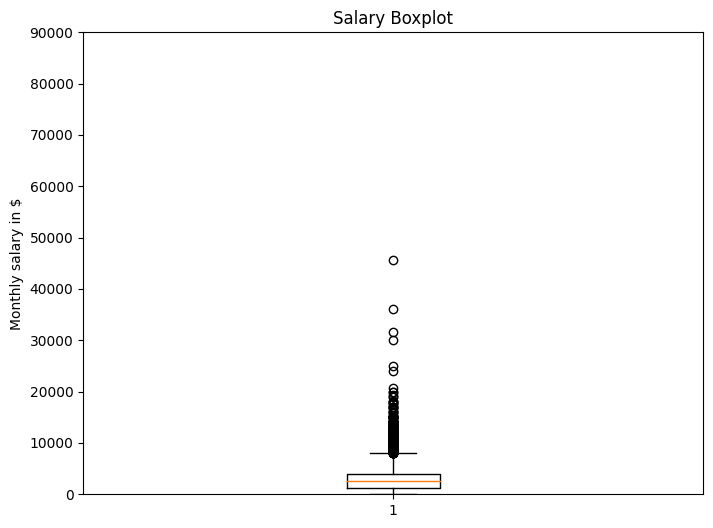

In [8]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['salary'])
plt.ylim(0,90000)
plt.title('Salary Boxplot')
plt.ylabel('Monthly salary in $')
plt.show()

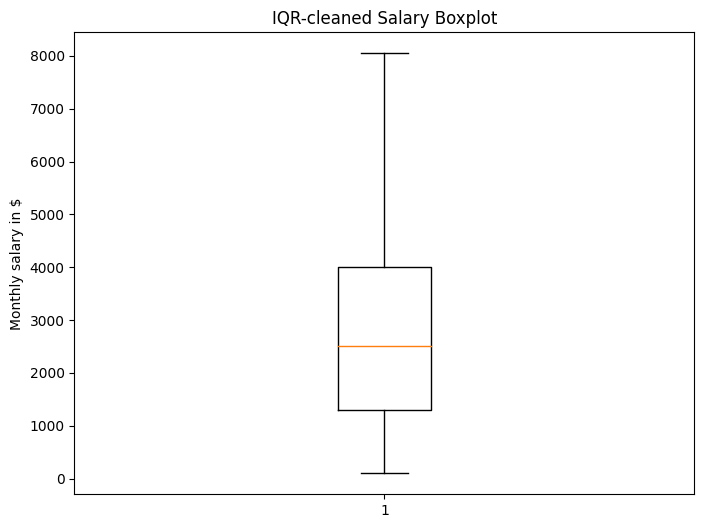

In [9]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_cleaned['salary'])
plt.title('IQR-cleaned Salary Boxplot')
plt.ylabel('Monthly salary in $')
plt.show()

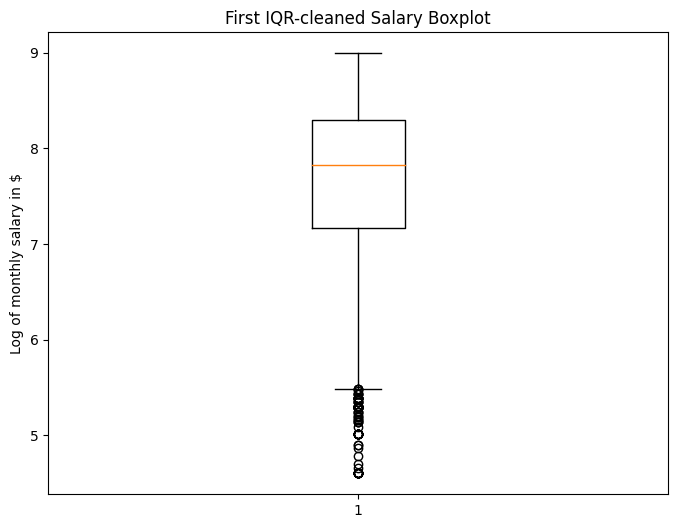

In [10]:
plt.figure(figsize=(8, 6))
plt.boxplot(np.log(data_cleaned['salary']))
plt.title('First IQR-cleaned Salary Boxplot')
plt.ylabel('Log of monthly salary in $')
plt.show()

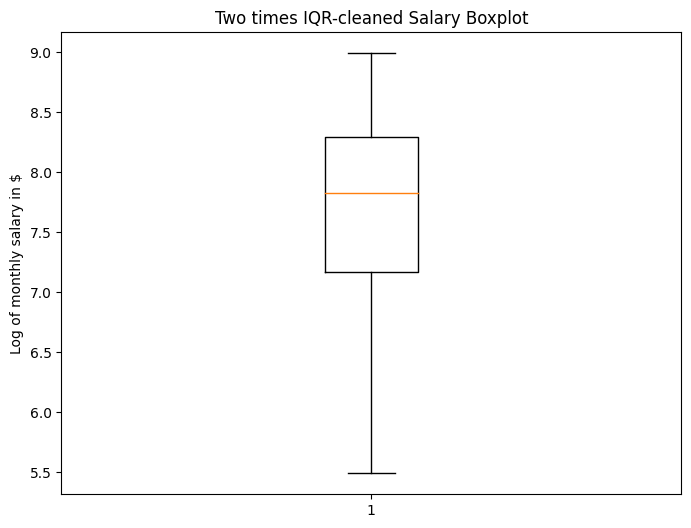

In [11]:
plt.figure(figsize=(8, 6))
plt.boxplot(np.log(data_log_cleaned['salary']))
plt.title('Two times IQR-cleaned Salary Boxplot')
plt.ylabel('Log of monthly salary in $')
plt.show()

In [13]:
x = pd.get_dummies(data_log_cleaned[columns+sphere_columns]) #transform data to dummy variables
y = np.log(data_log_cleaned['salary']) #get logarithm of salary

In [14]:
# devide data to train, validation, taking into account quantiles to ensure similar data distribution in train and test

n_quantiles = 100

quantiles = np.linspace(0, 1, n_quantiles + 1)
y_quantiles = np.quantile(y, quantiles)
y_quantile_labels = np.digitize(y, y_quantiles)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, stratify=y_quantile_labels, test_size=0.15, random_state=42)

In [15]:
print('Train + validation data length:',len(x_train_val))
print('Test data length:', len(x_test))

Train + validation data length: 53456
Test data length: 9434


# Visualizations

In [16]:
pr_qa_data = data_log_cleaned.drop(data_log_cleaned[~data_log_cleaned['specialisation'].isin(['programming','qa'])].index) #programmists and qa data
other_data = data_log_cleaned.drop(pr_qa_data.index) #other specialisations data

Education and English plot

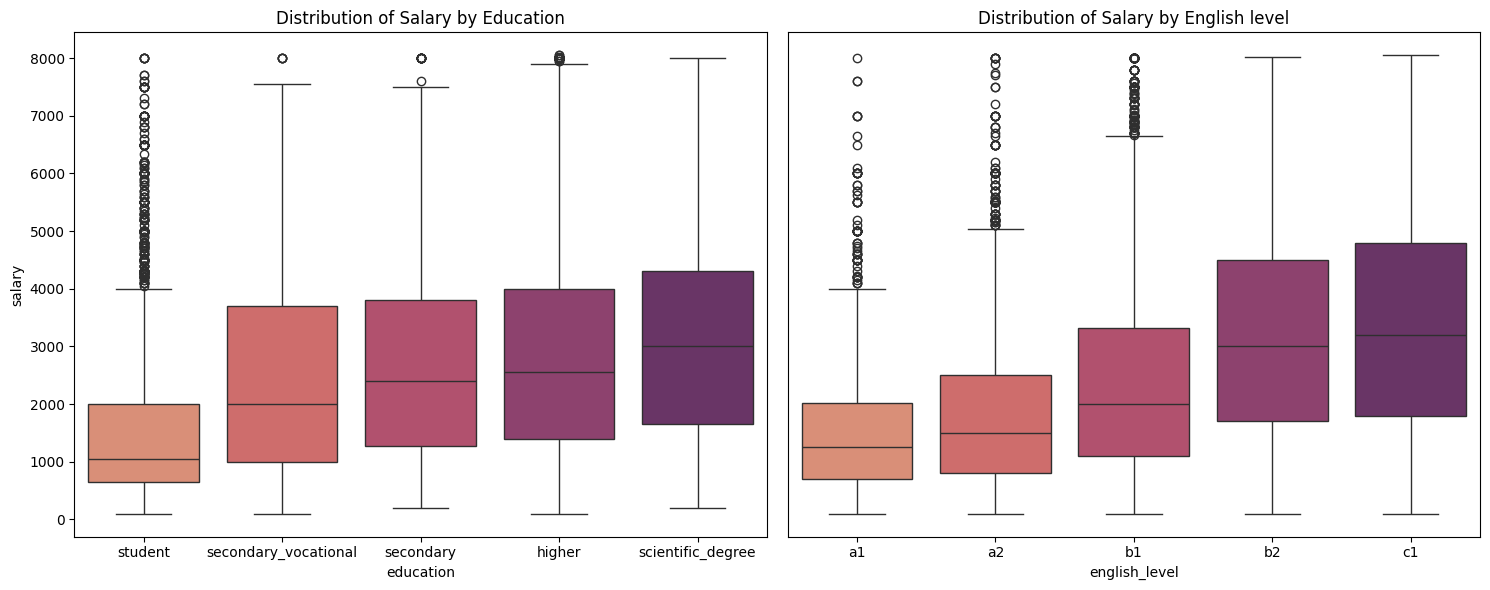

In [17]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

groped_data_spec =  data_cleaned[['salary','education']].groupby(['education']).median().sort_values(by='salary')
sns.color_palette("mako", as_cmap=True)
sns.boxplot(y=data_cleaned['salary'], x=data['education'],order=groped_data_spec.index,palette=sns.color_palette("flare",n_colors=len(data_cleaned['education'].unique())))
plt.title('Distribution of Salary by Education')
plt.tight_layout()

plt.subplot(1, 2, 2)
groped_data_spec =  data_cleaned[['salary','english_level']].groupby(['english_level']).median().sort_values(by='salary')
sns.color_palette("mako", as_cmap=True)
sns.boxplot(y=data_cleaned['salary'], x=data['english_level'],order=groped_data_spec.index,palette=sns.color_palette("flare",n_colors=len(data_cleaned['english_level'].unique())))
plt.title('Distribution of Salary by English level')
plt.yticks([])
plt.ylabel('')

plt.show()

Visualize salary distribution by experience, age and job level

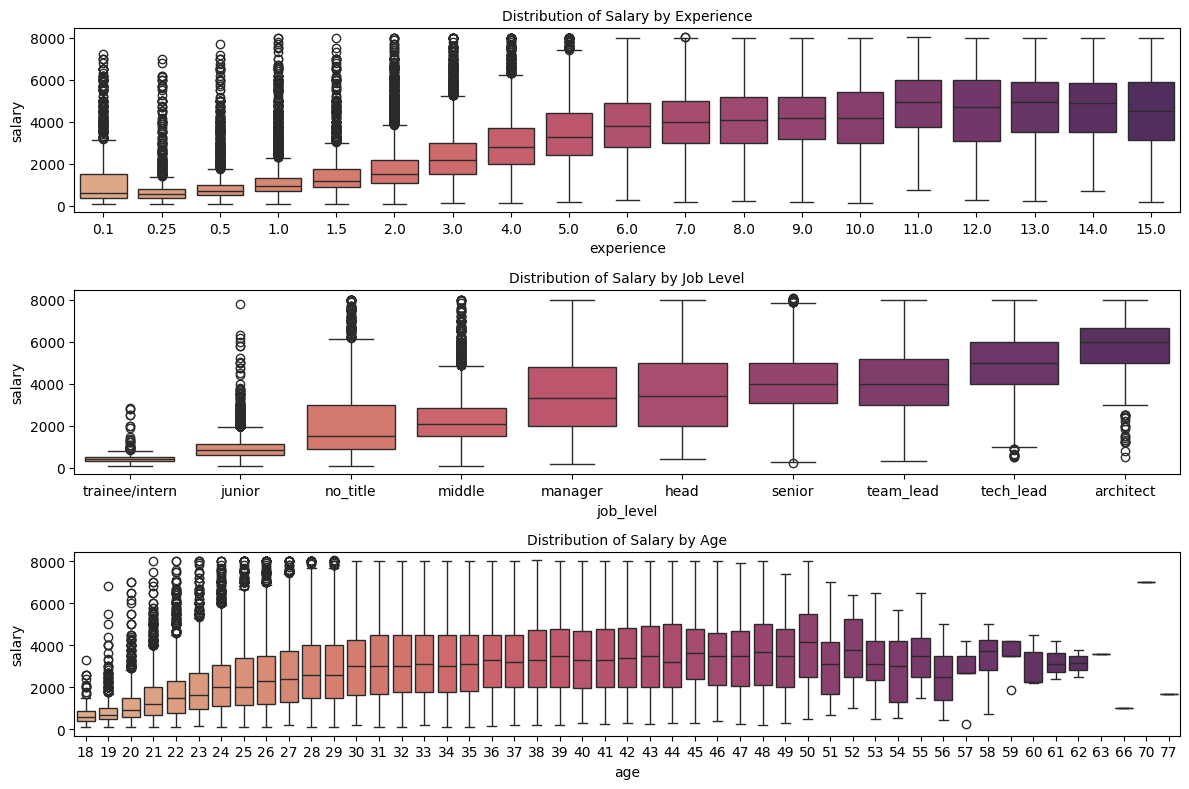

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)

groped_data_spec =  data_cleaned[['salary','experience']].groupby(['experience']).median().sort_values(by='salary')
sns.color_palette("mako", as_cmap=True)
sns.boxplot(y=data_cleaned['salary'], x=data['experience'],palette=sns.color_palette("flare",n_colors=len(data_cleaned['experience'].unique())))
plt.title('Distribution of Salary by Experience',fontsize=10)

plt.subplot(3, 1, 2)
groped_data_spec =  data_cleaned[['salary','job_level']].groupby(['job_level']).median().sort_values(by='salary')
sns.color_palette("mako", as_cmap=True)
sns.boxplot(y=data_cleaned['salary'], x=data['job_level'],order=groped_data_spec.index,palette=sns.color_palette("flare",n_colors=len(data_cleaned['job_level'].unique())))
plt.title('Distribution of Salary by Job Level',fontsize=10)

plt.subplot(3, 1, 3)
groped_data_spec =  data_cleaned[['salary','age']].groupby(['age']).median().sort_values(by='salary')
sns.color_palette("mako", as_cmap=True)
sns.boxplot(y=data_cleaned['salary'], x=data['age'],palette=sns.color_palette("flare",n_colors=len(data_cleaned['age'].unique())))
plt.title('Distribution of Salary by Age',fontsize=10)
plt.tight_layout()

plt.show()

Visualize distribution of specialisation by gender

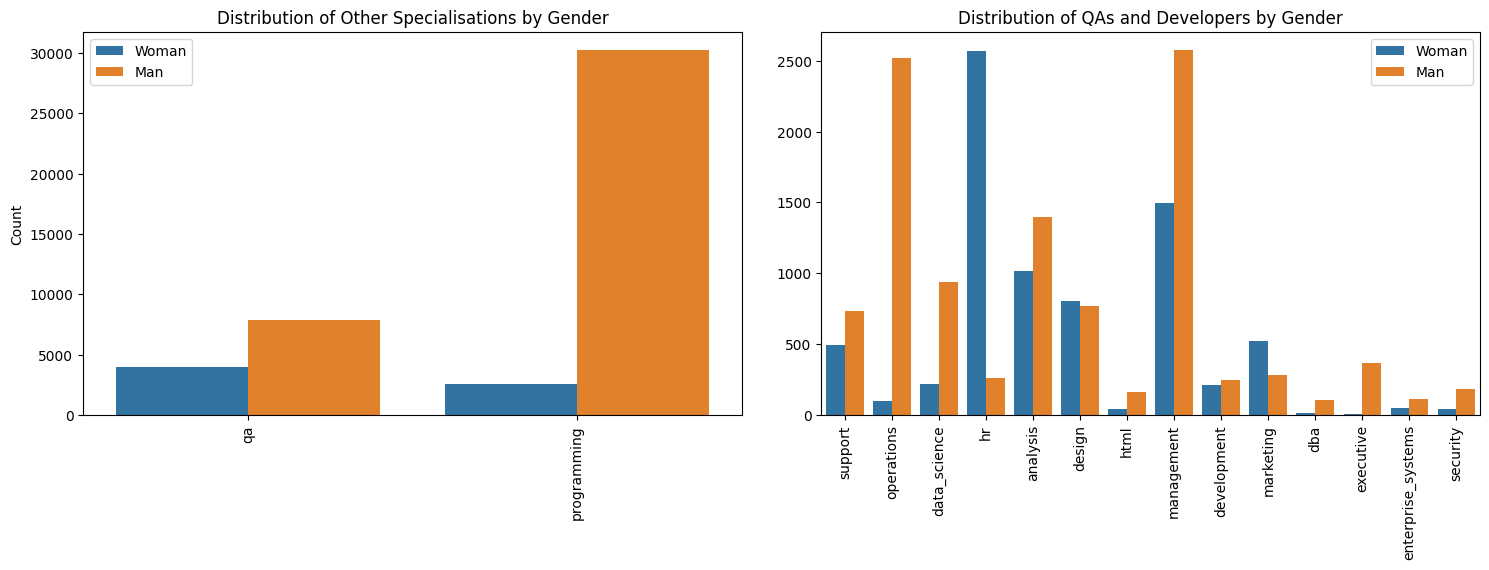

In [19]:

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='specialisation', hue='gender', data=data_log_cleaned.drop(data_log_cleaned[~data_log_cleaned['specialisation'].isin(['programming','qa'])].index))
plt.xlabel('Specialisation')
plt.ylabel('Count')
label_map = { '1': 'Man', '0': 'Woman',}
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [label_map[label] for label in labels])
plt.title('Distribution of Other Specialisations by Gender')
plt.xticks(rotation=90)
plt.tight_layout()
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.countplot(x='specialisation', hue='gender', data=data_log_cleaned.drop(data_log_cleaned[data_log_cleaned['specialisation'].isin(['programming','qa'])].index))
plt.xlabel('Specialisation')
plt.ylabel('Count')
plt.xticks(rotation=90)
label_map = {'0': 'Woman', '1': 'Man'}
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [label_map[label] for label in labels])
plt.tight_layout()
plt.ylabel('')
plt.xlabel('')


plt.title('Distribution of QAs and Developers by Gender')
plt.show()

Visualize salary distribution by all columns categories

In [20]:
def salary_dastribution_plot(column_name):
    groped_data_spec =  data_cleaned[['salary',column_name]].groupby([column_name]).median().sort_values(by='salary')

    sns.color_palette("mako", as_cmap=True)
    plt.figure(figsize=(25,6))
    sns.boxplot(y=np.log(data_cleaned['salary']), x=data[column_name],order=groped_data_spec.index,palette=sns.color_palette("flare",n_colors=len(data_cleaned[column_name].unique())))
    plt.xticks(rotation=90)
    plt.show()



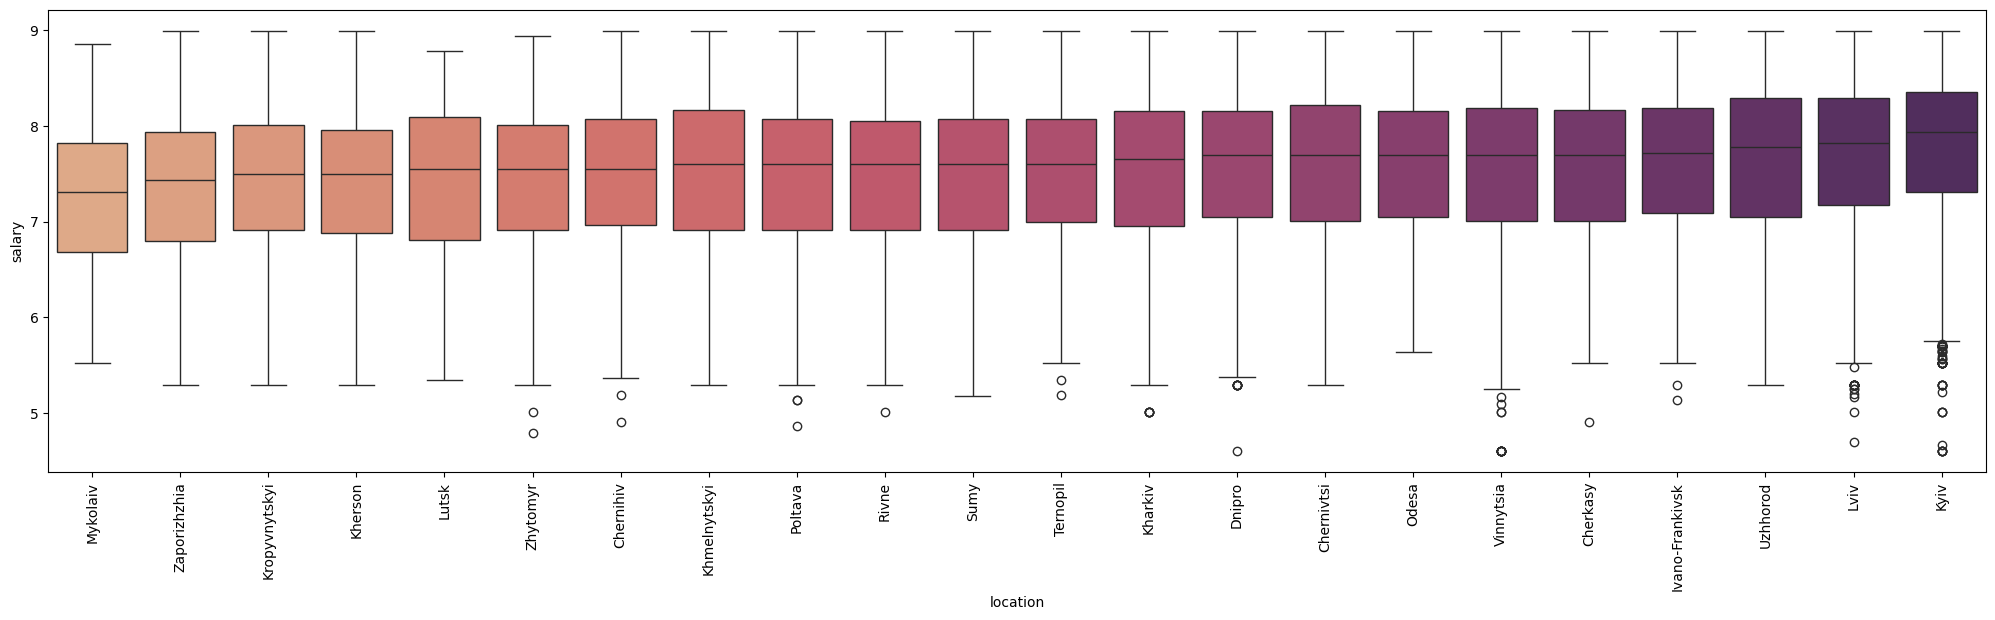

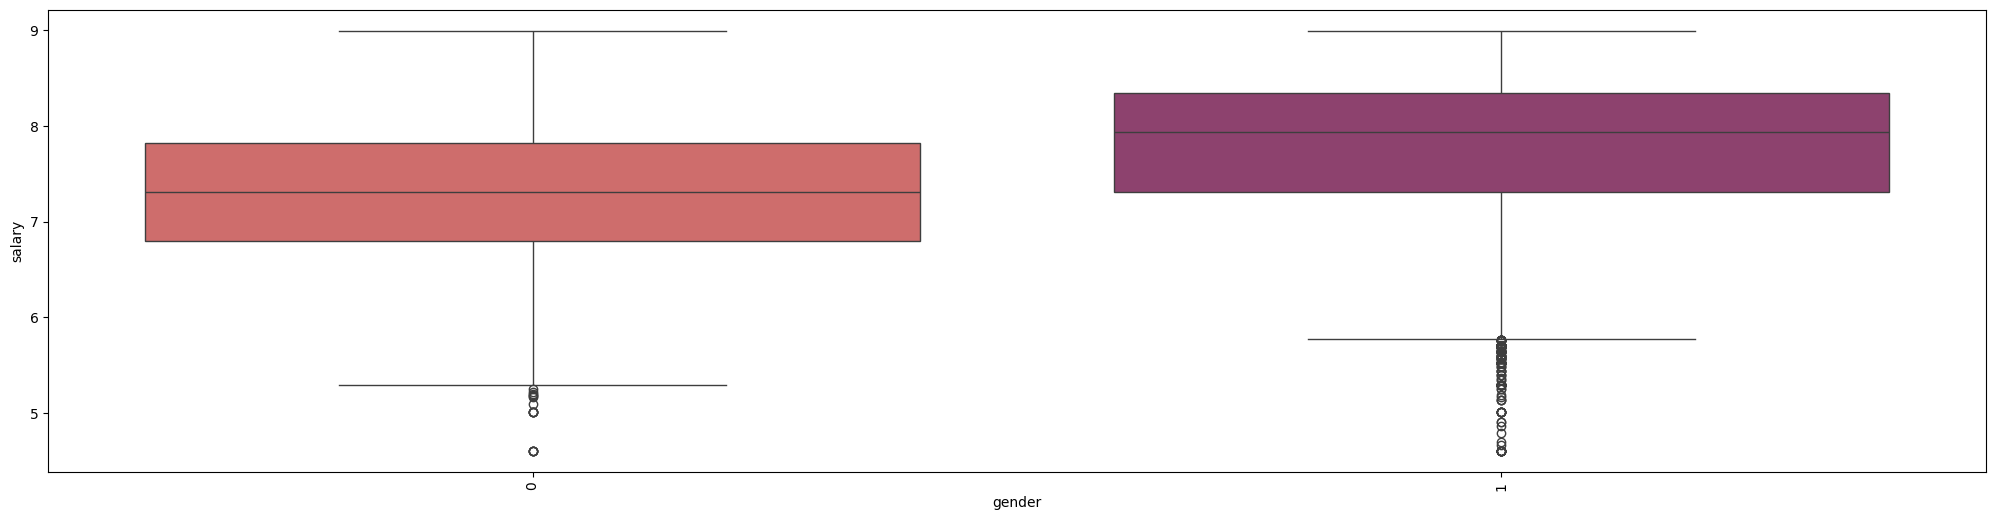

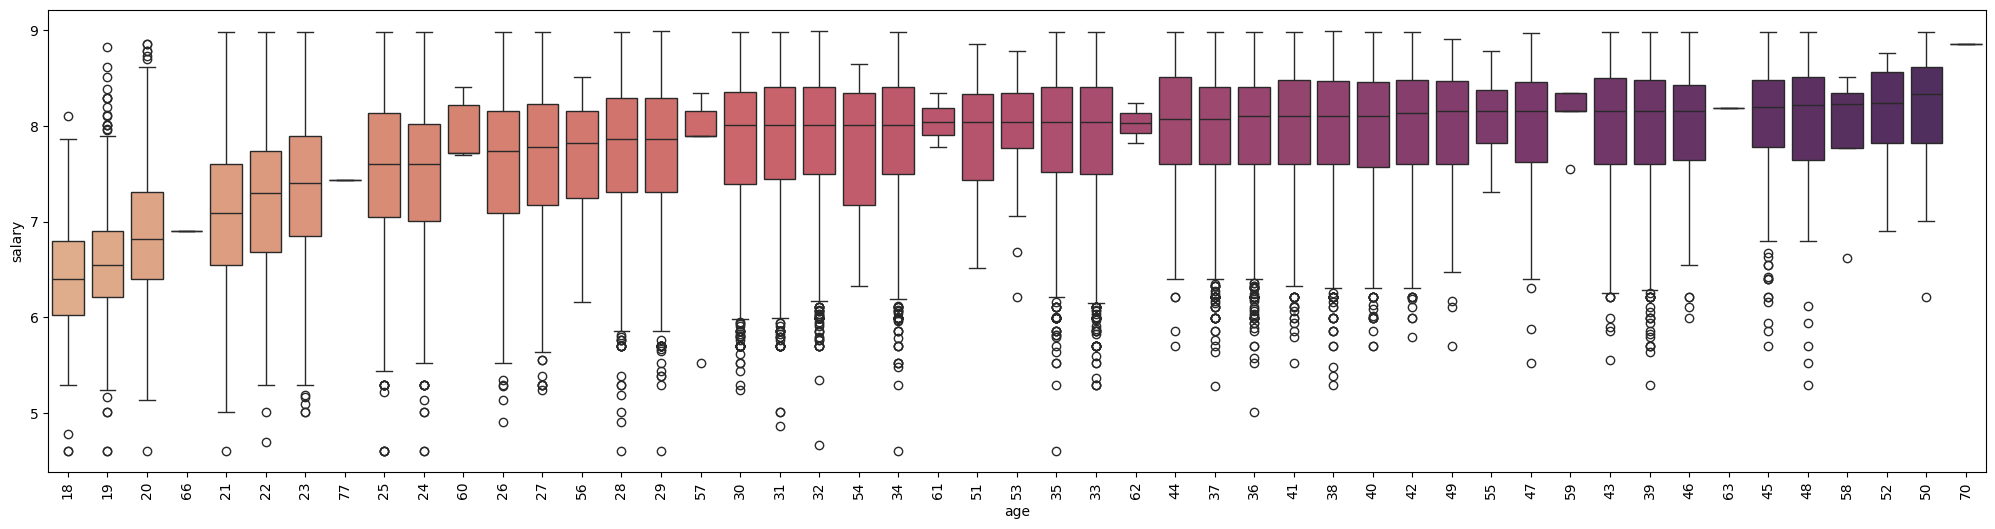

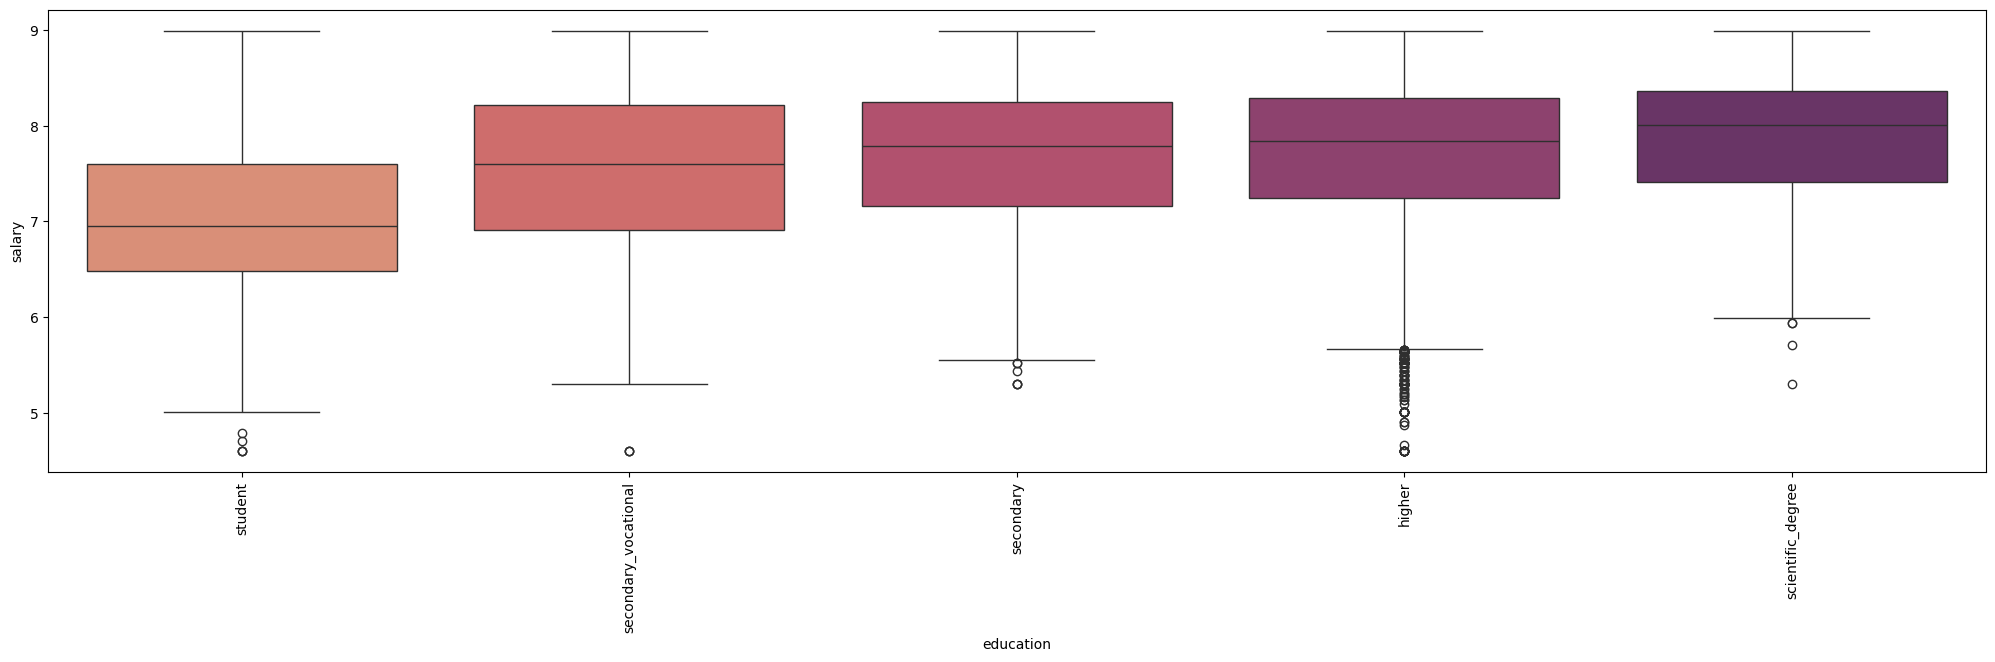

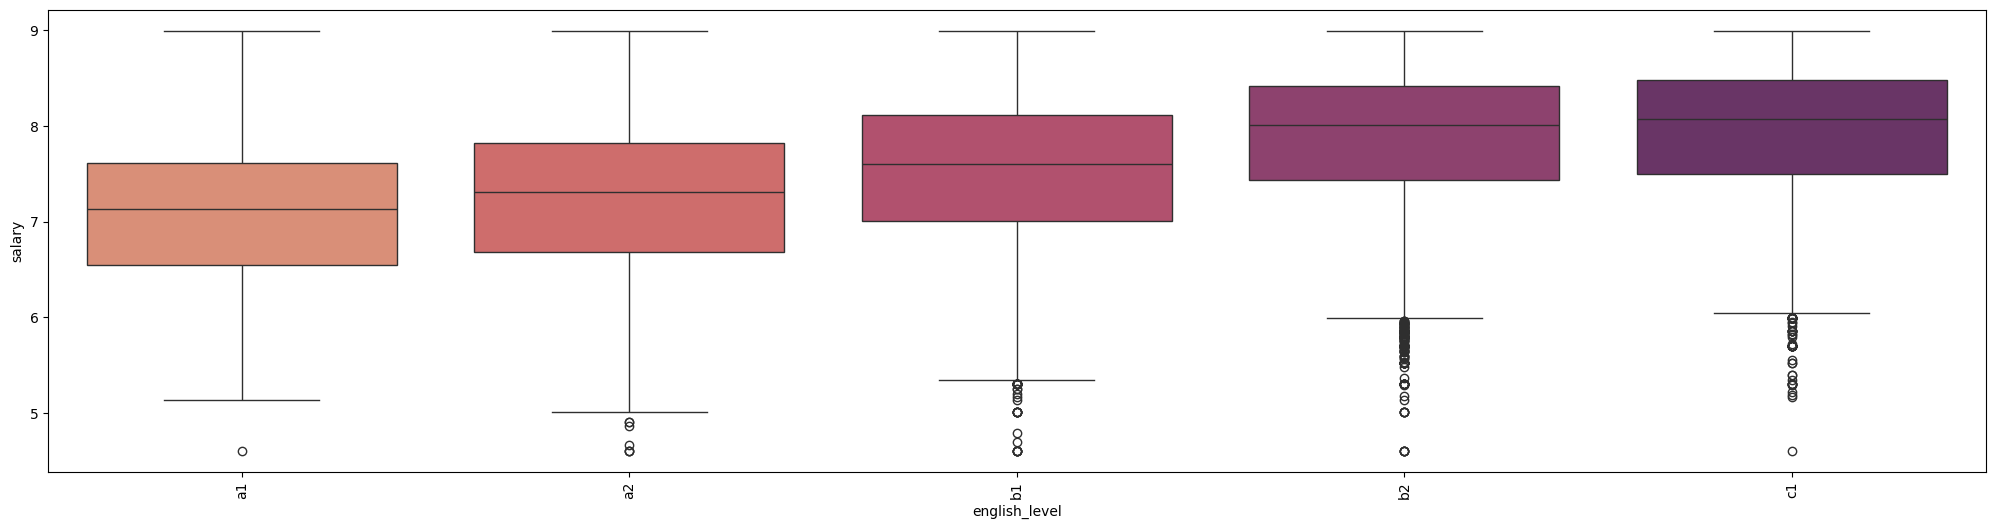

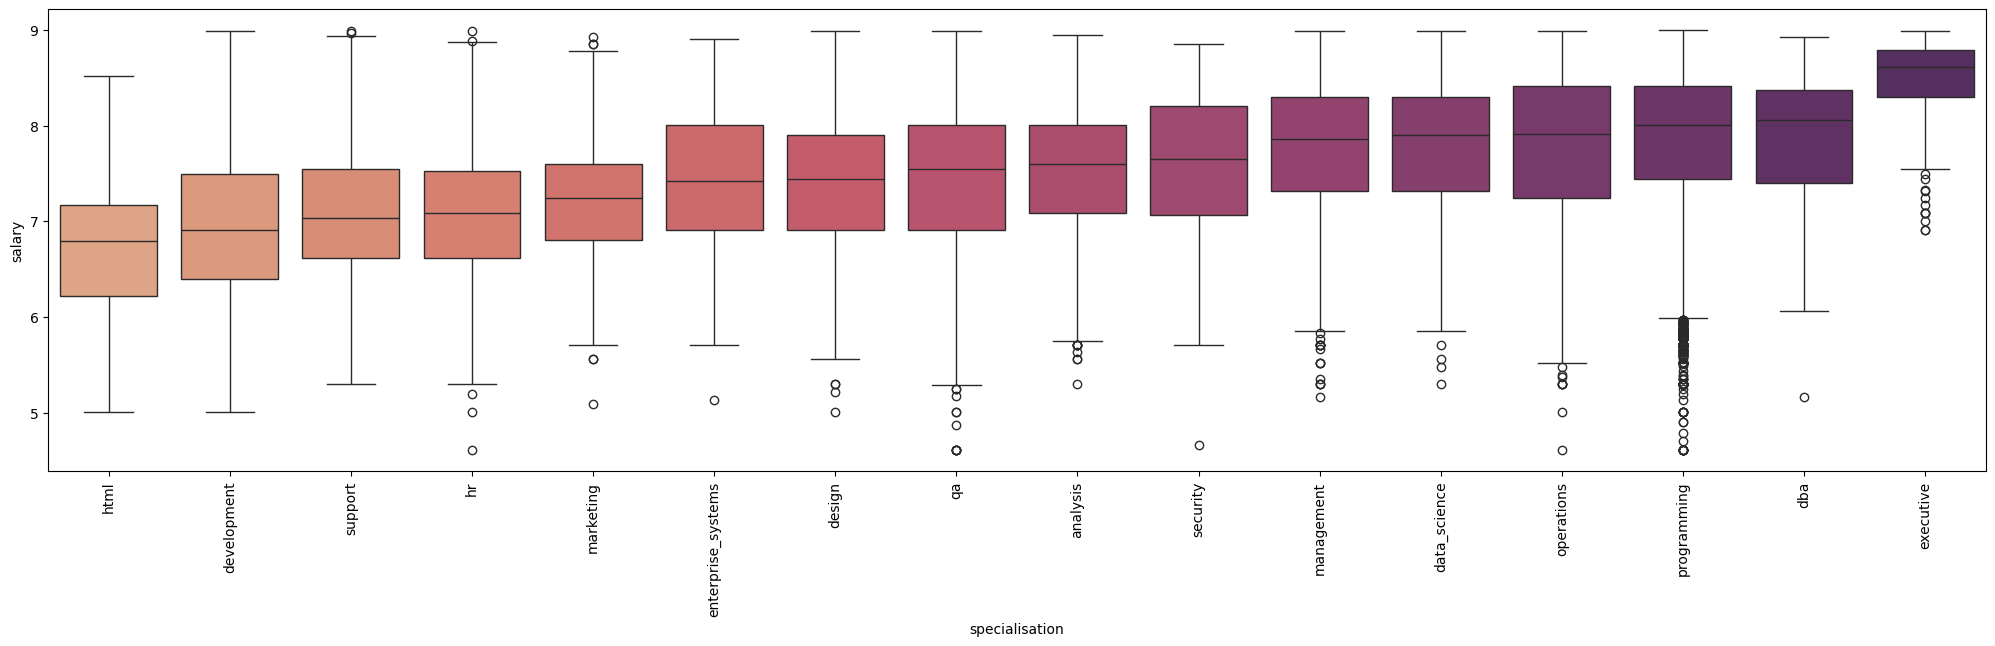

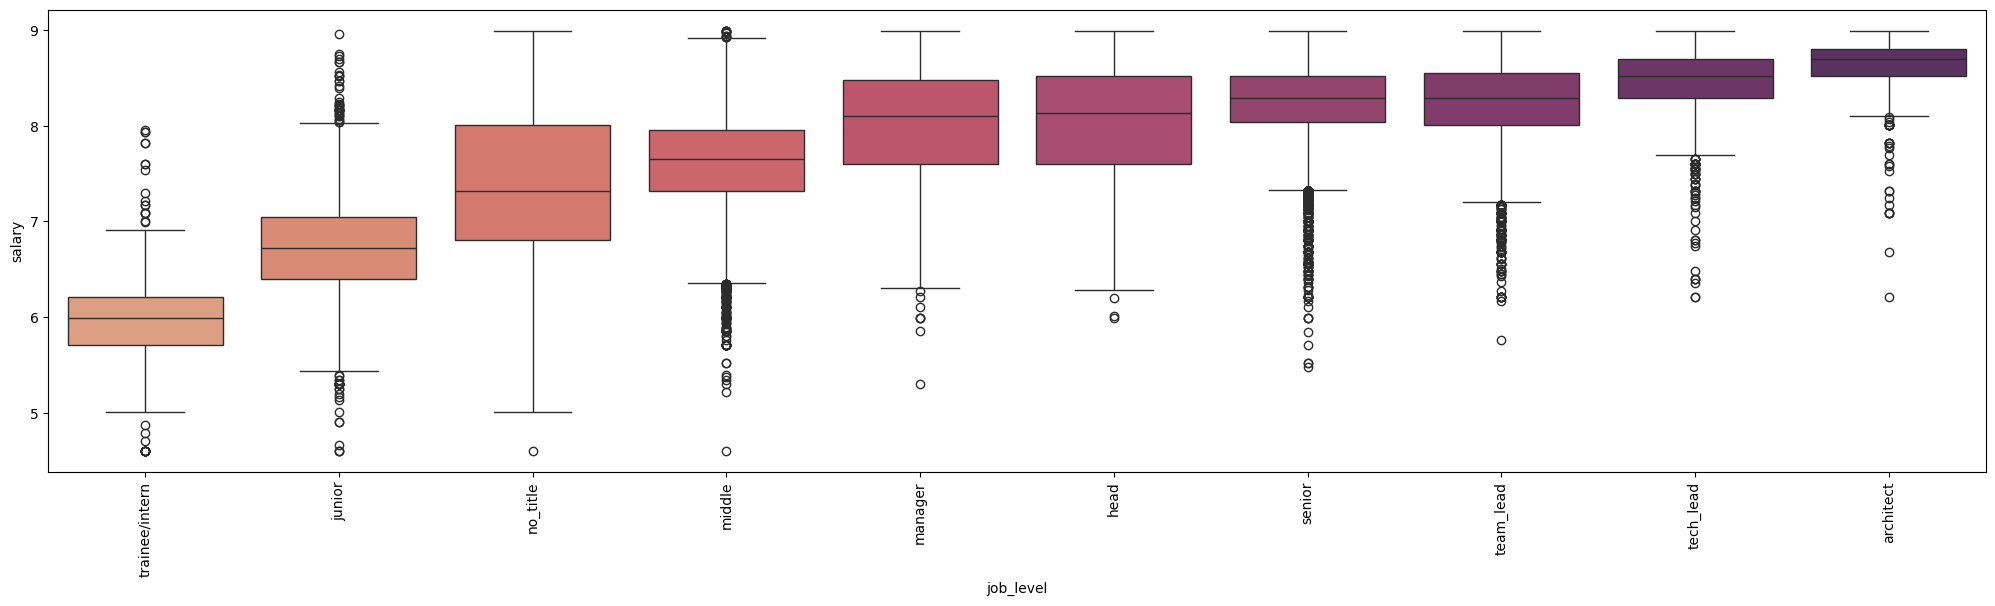

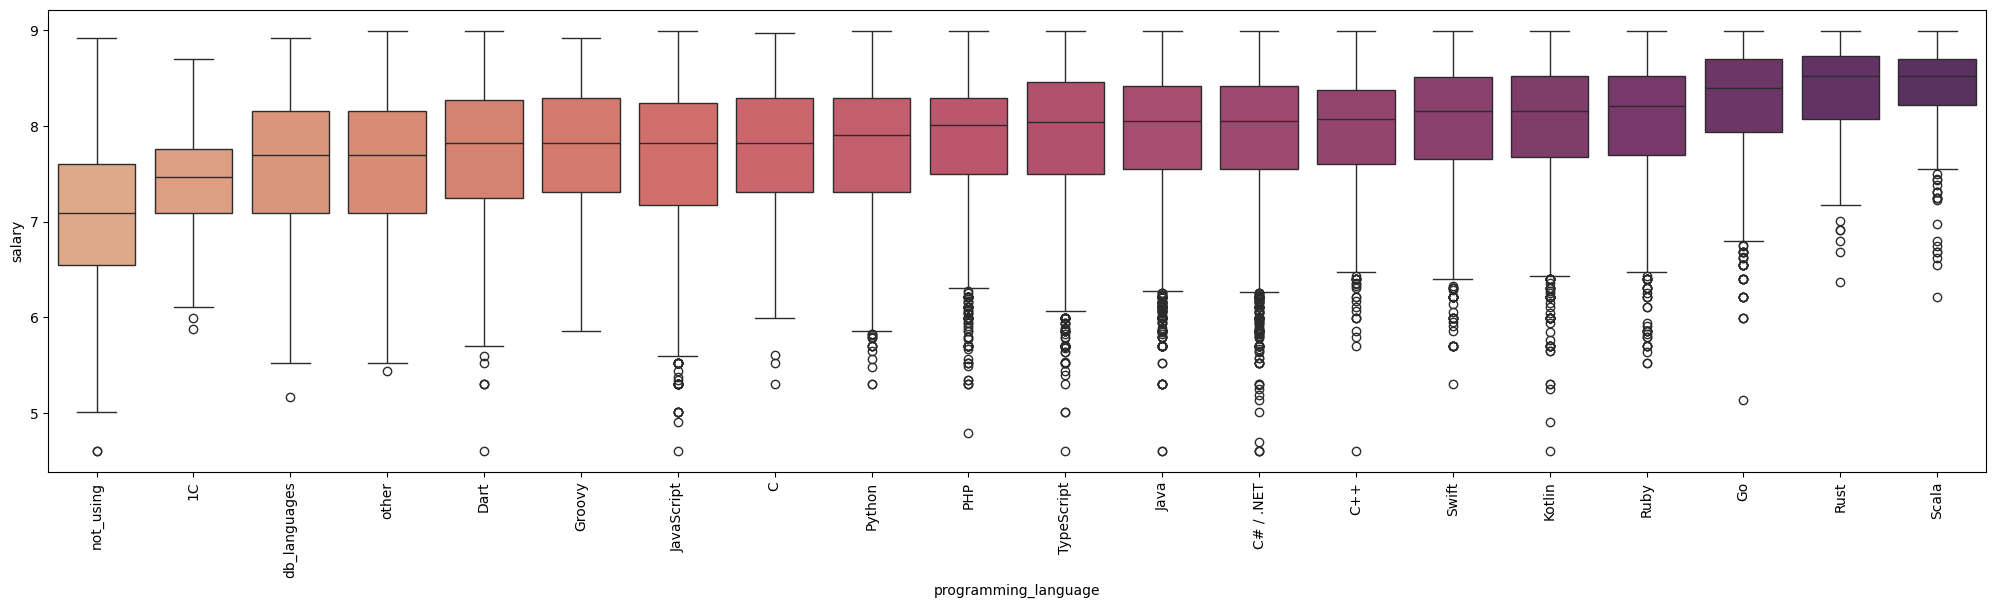

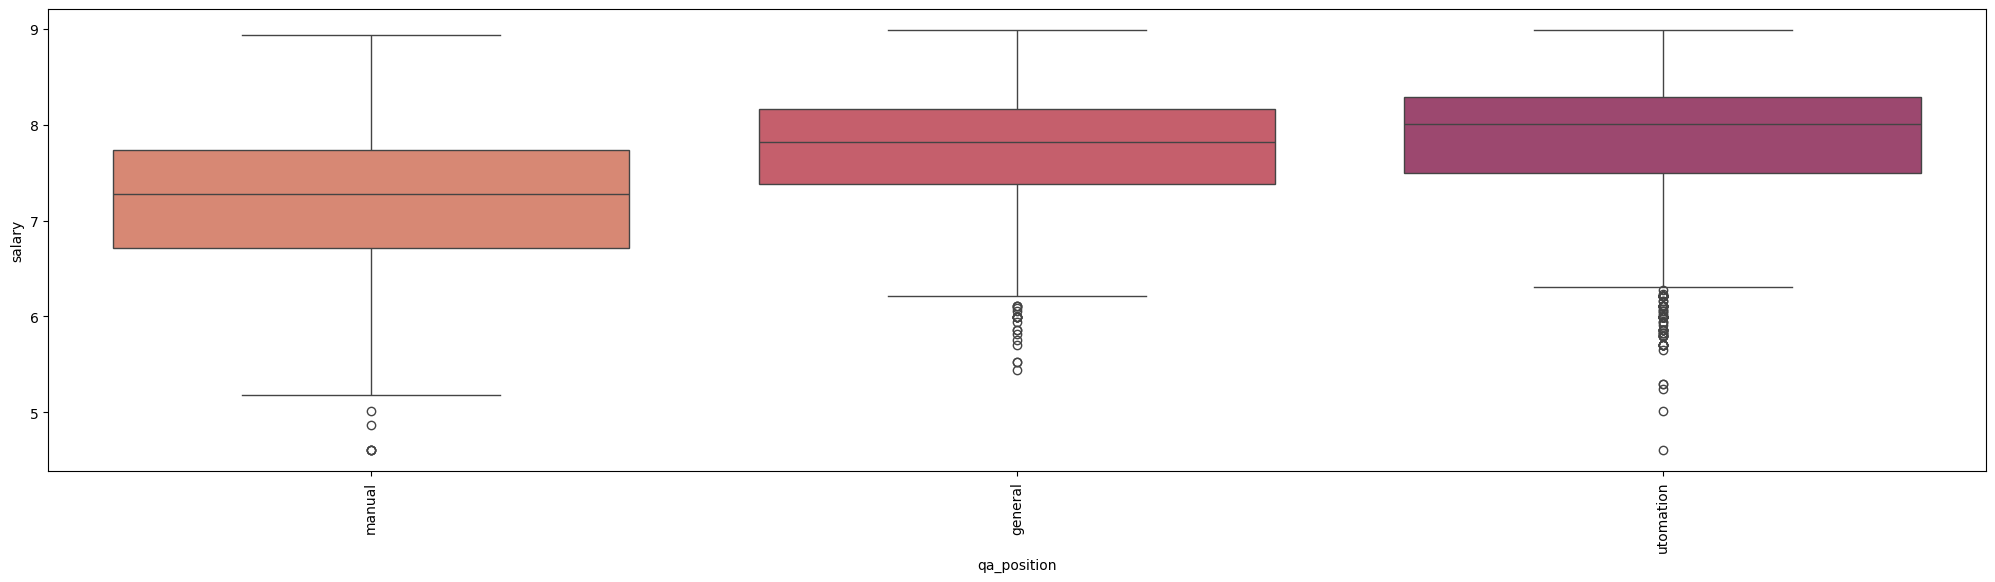

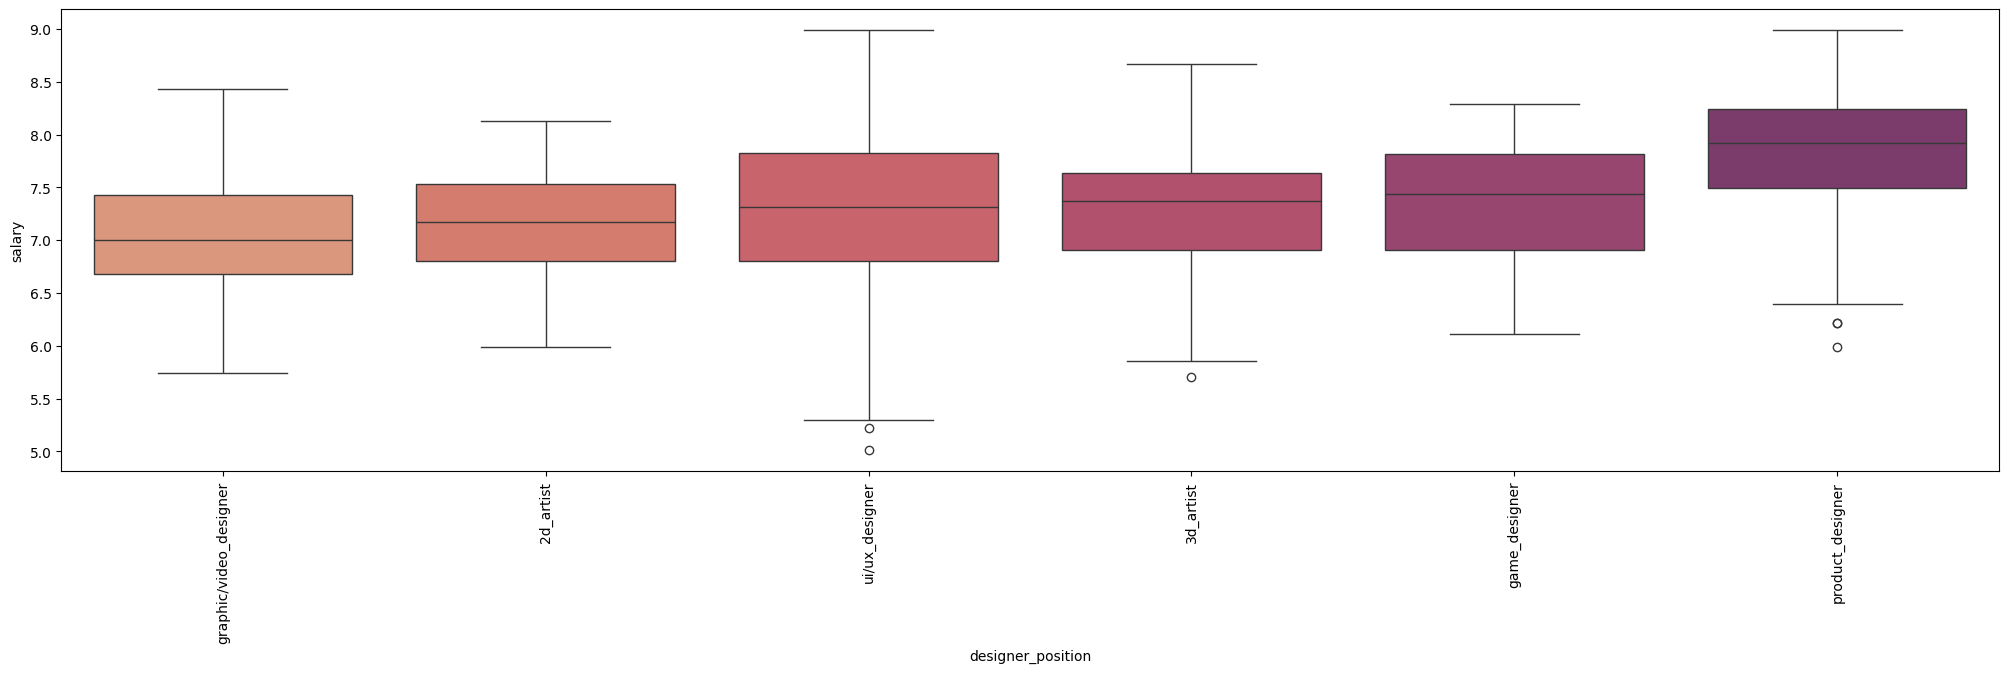

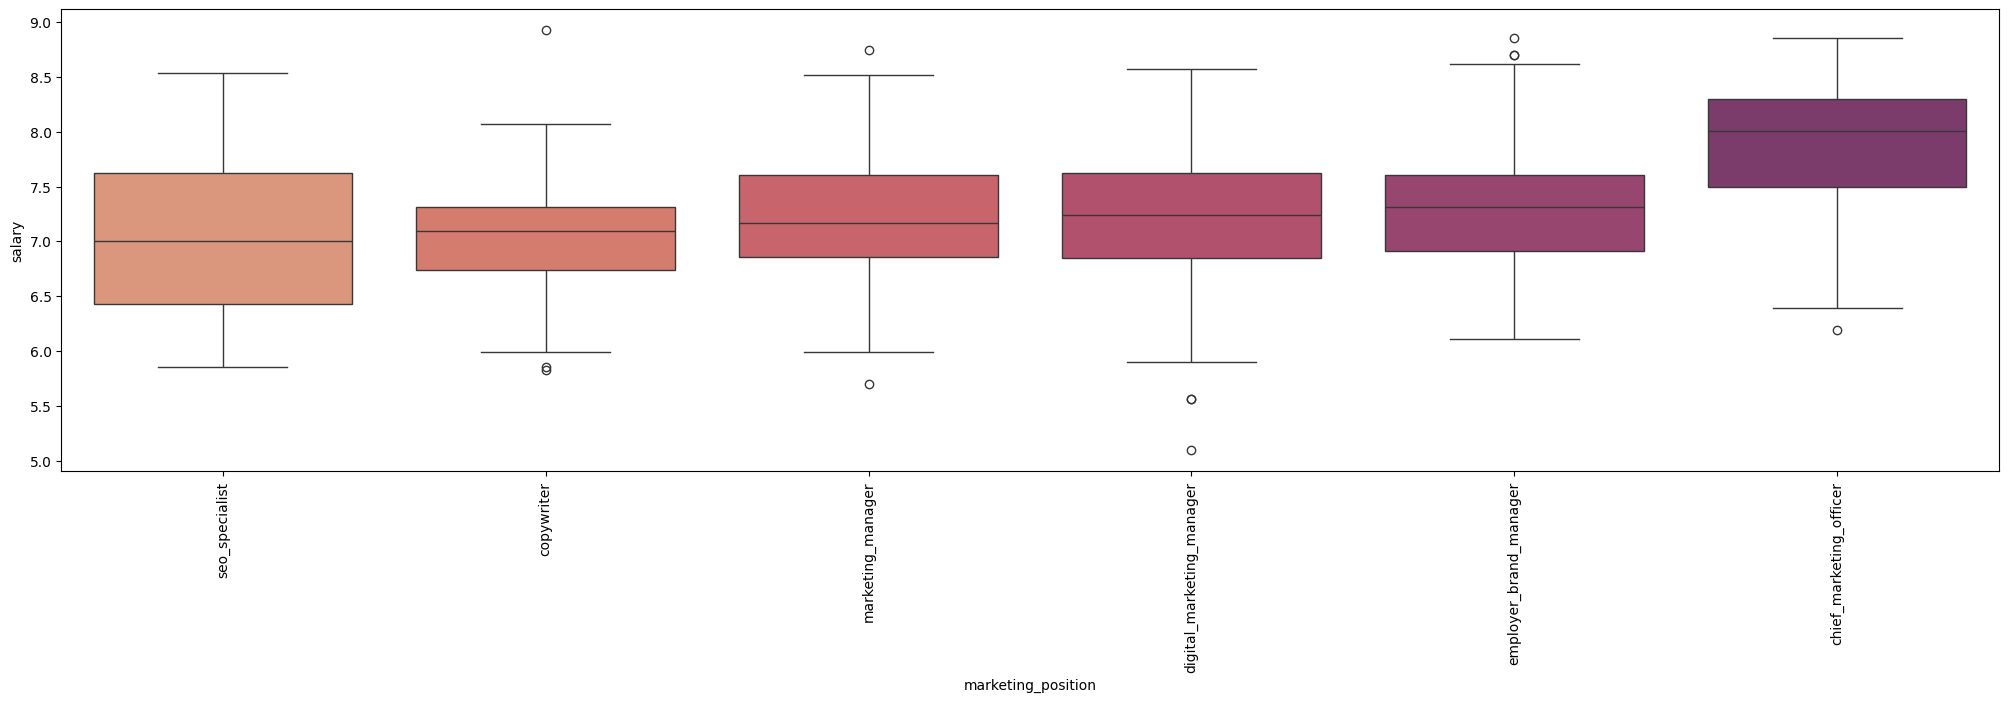

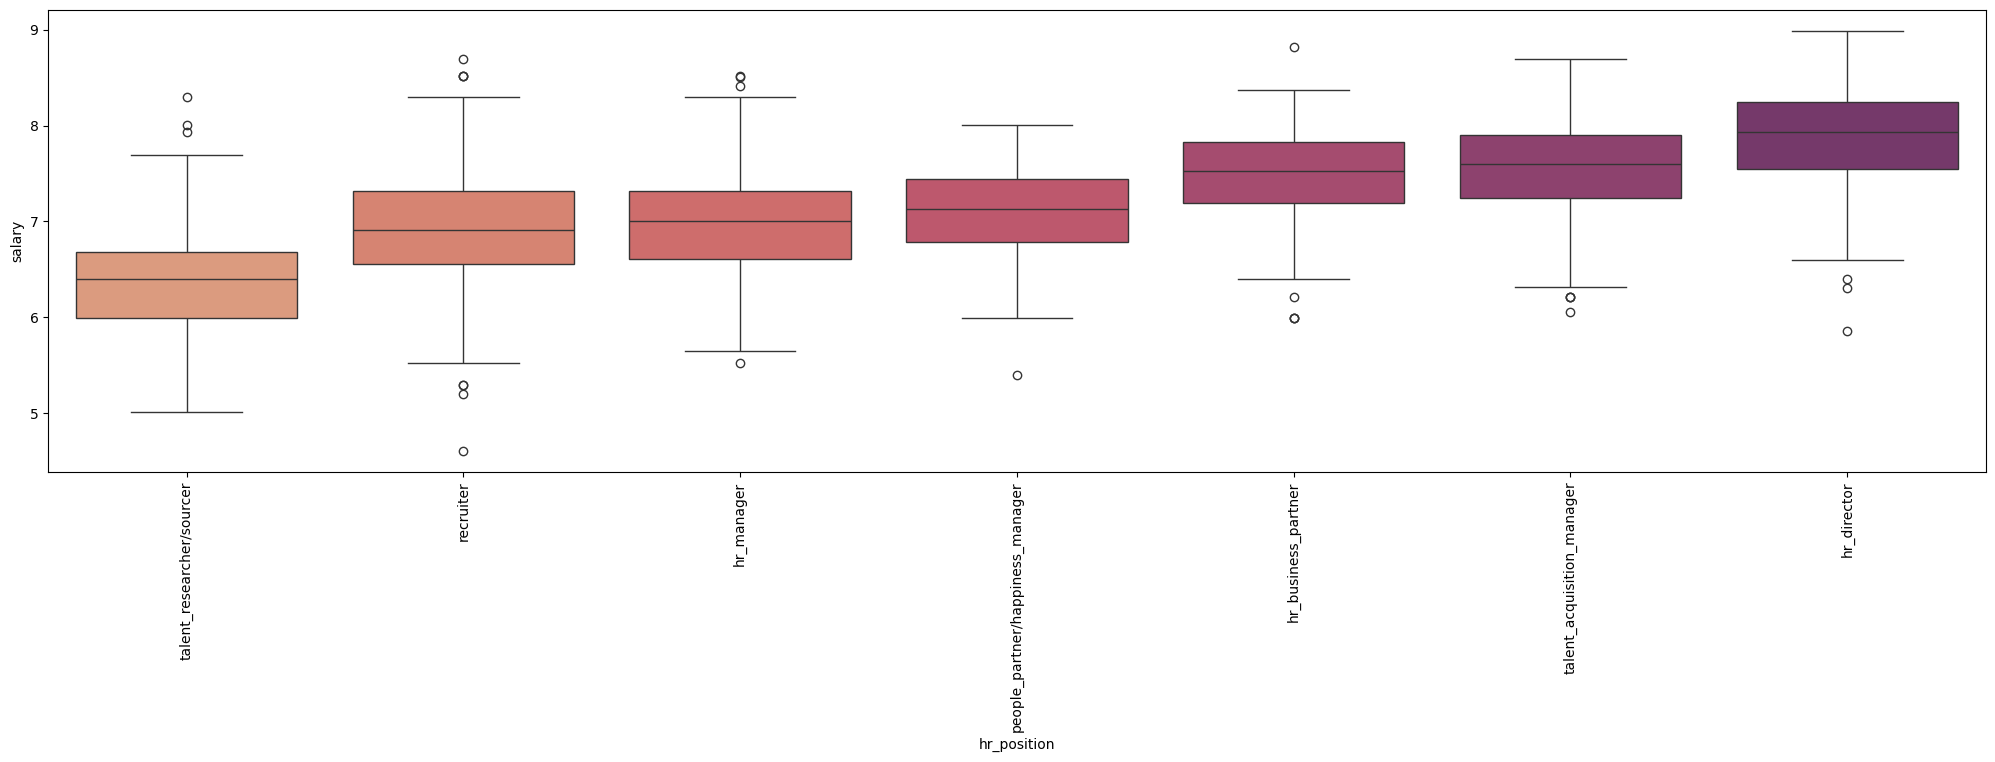

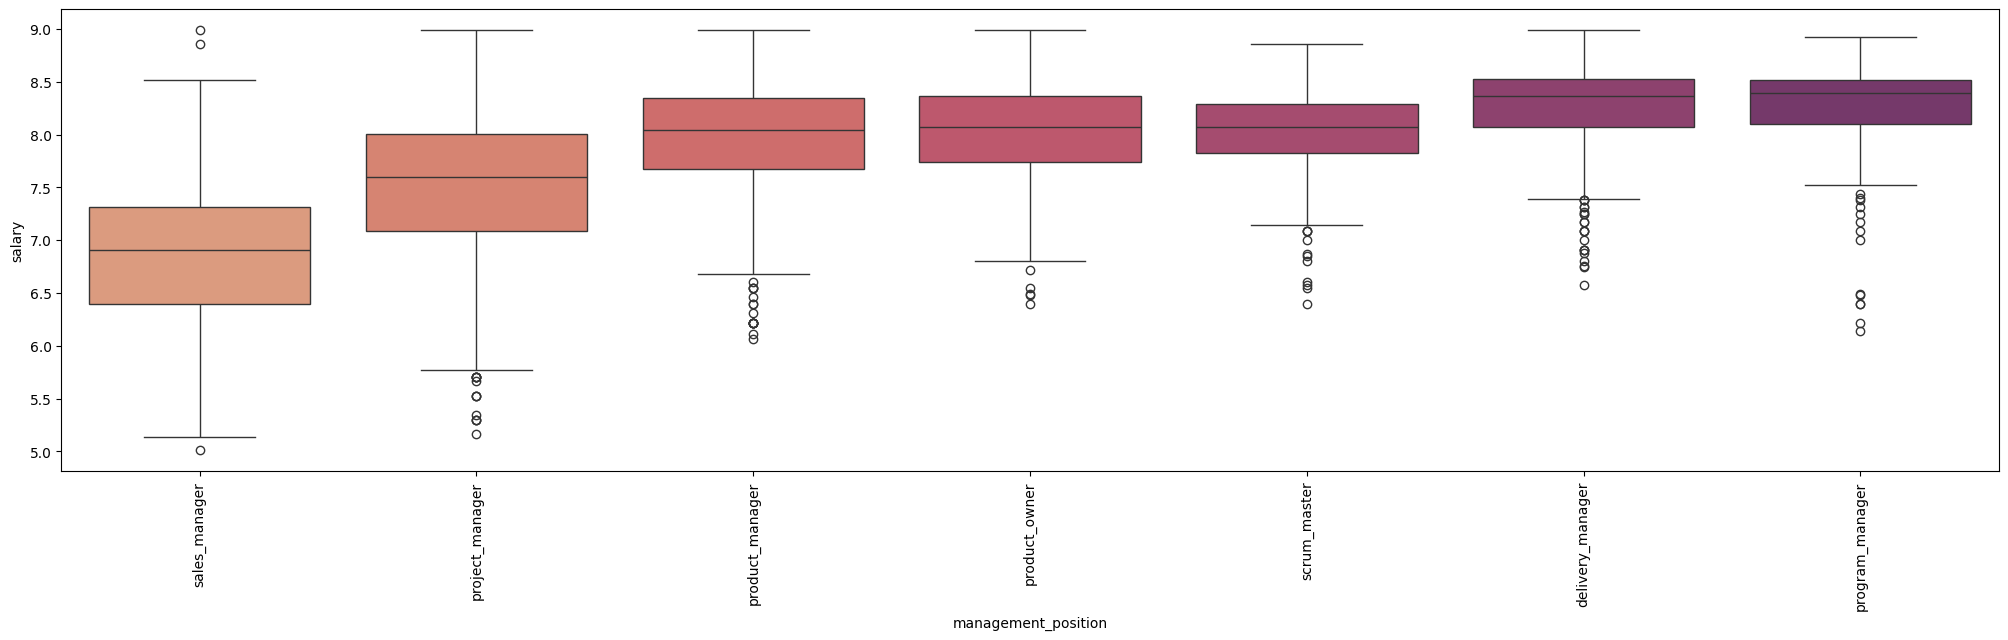

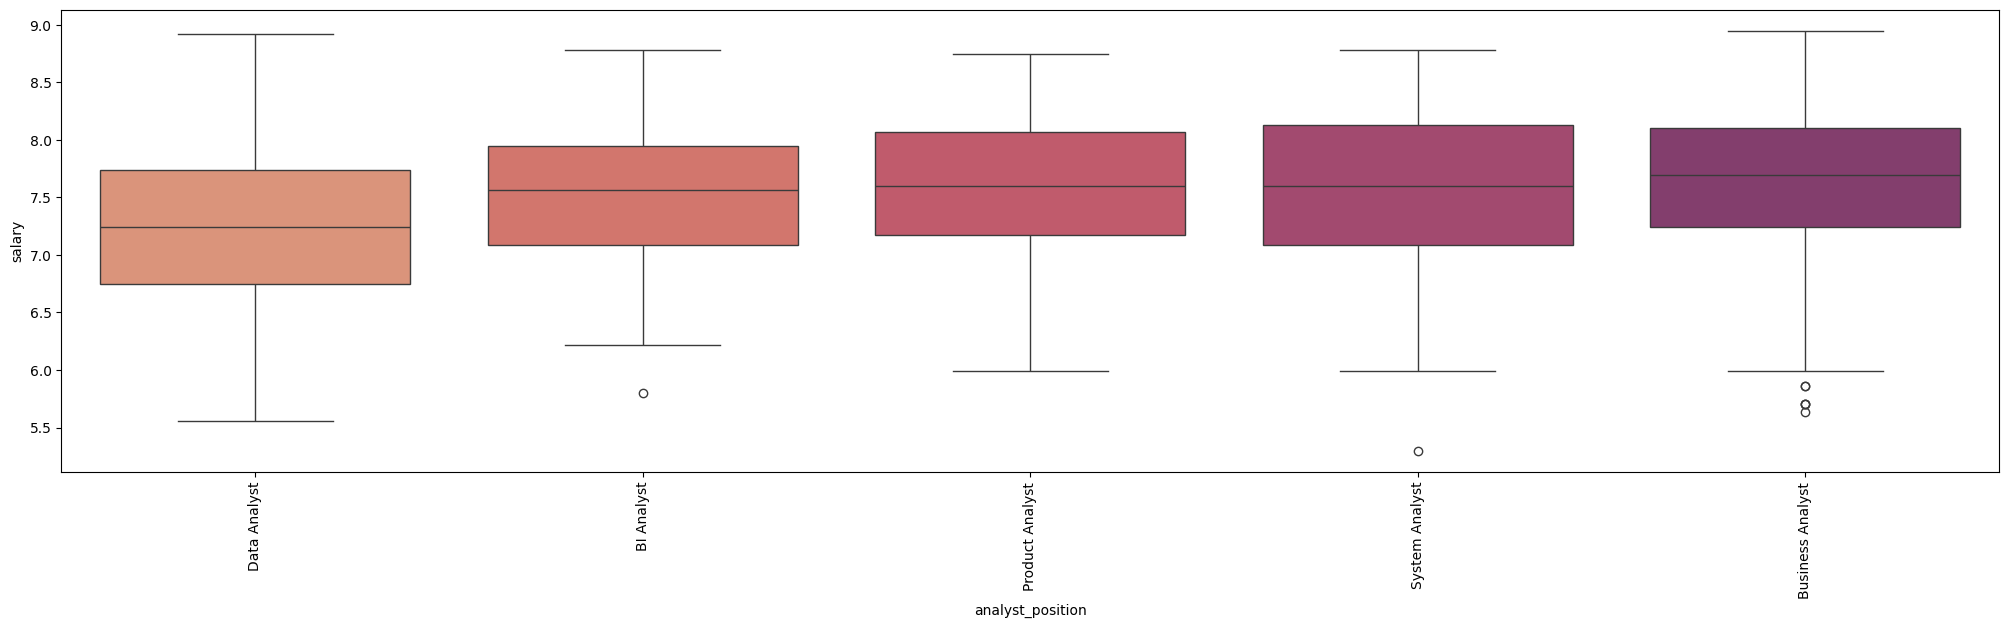

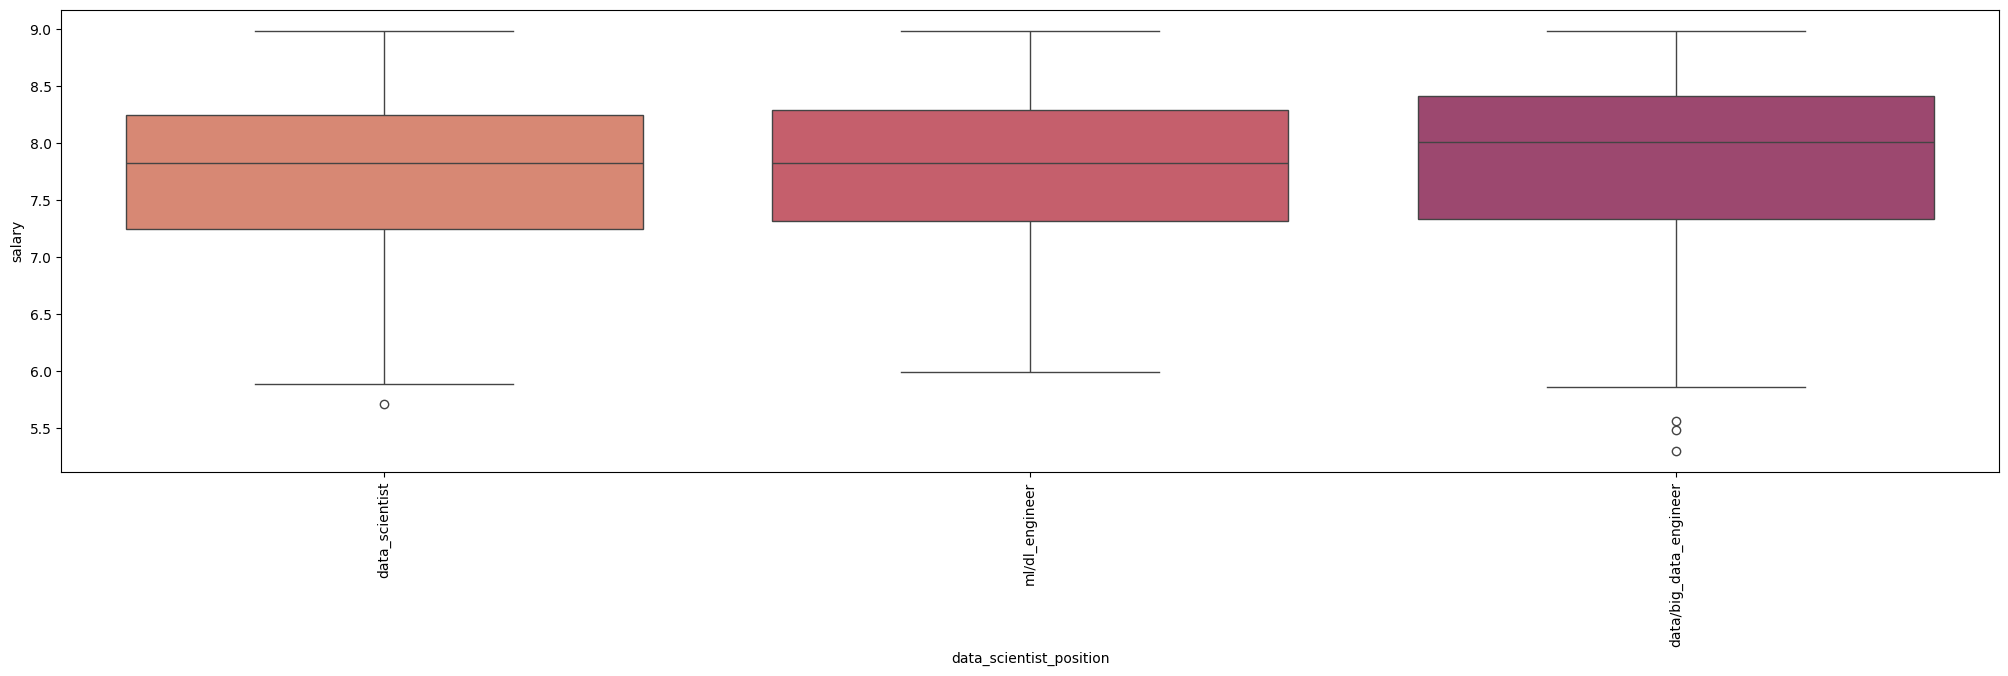

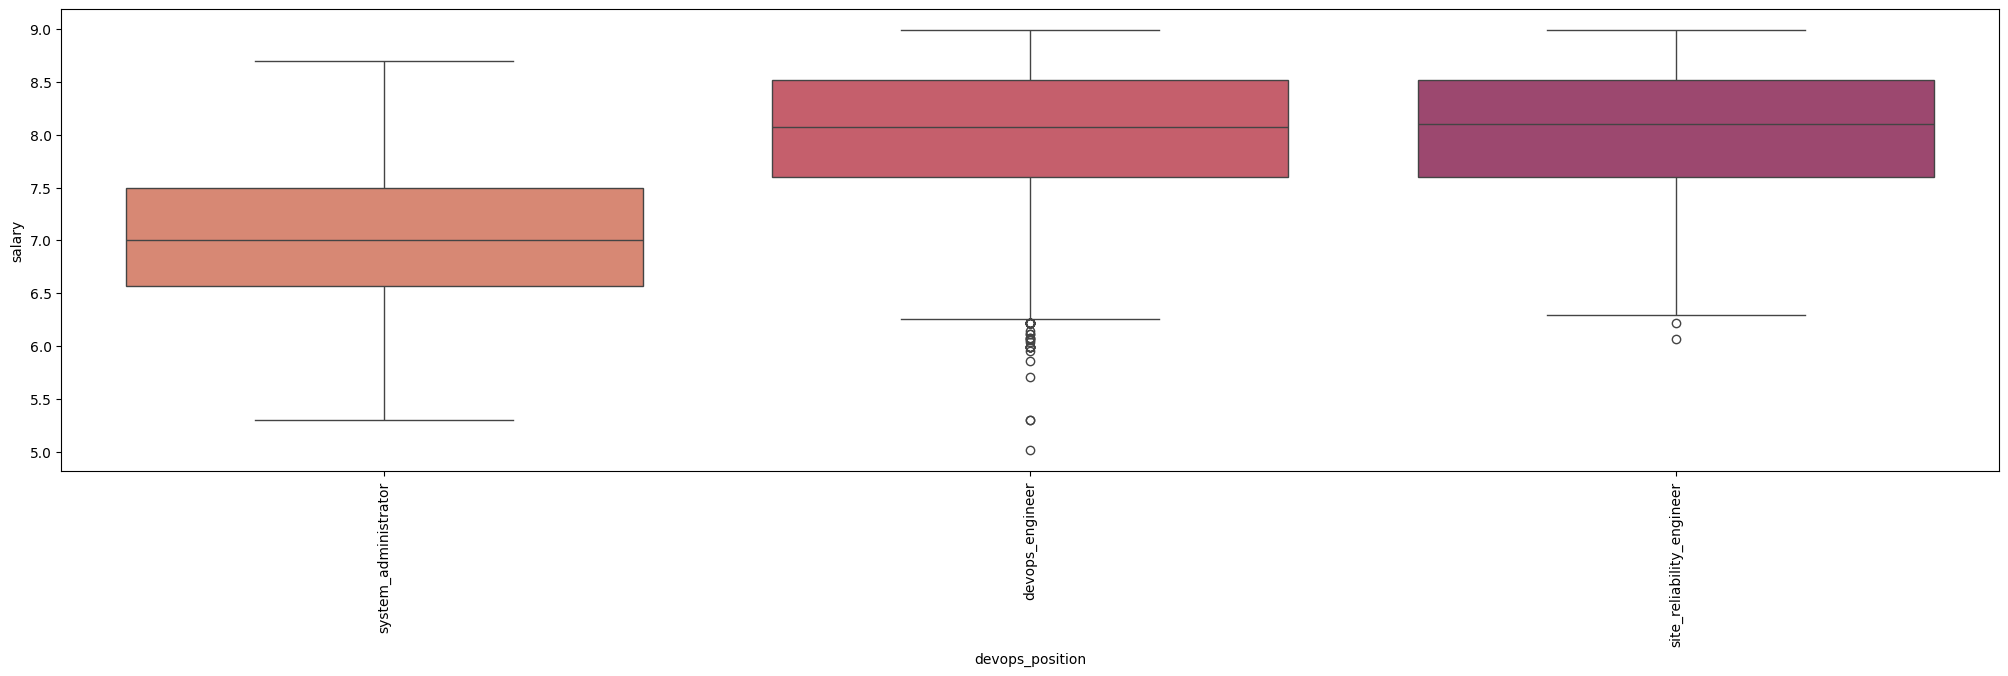

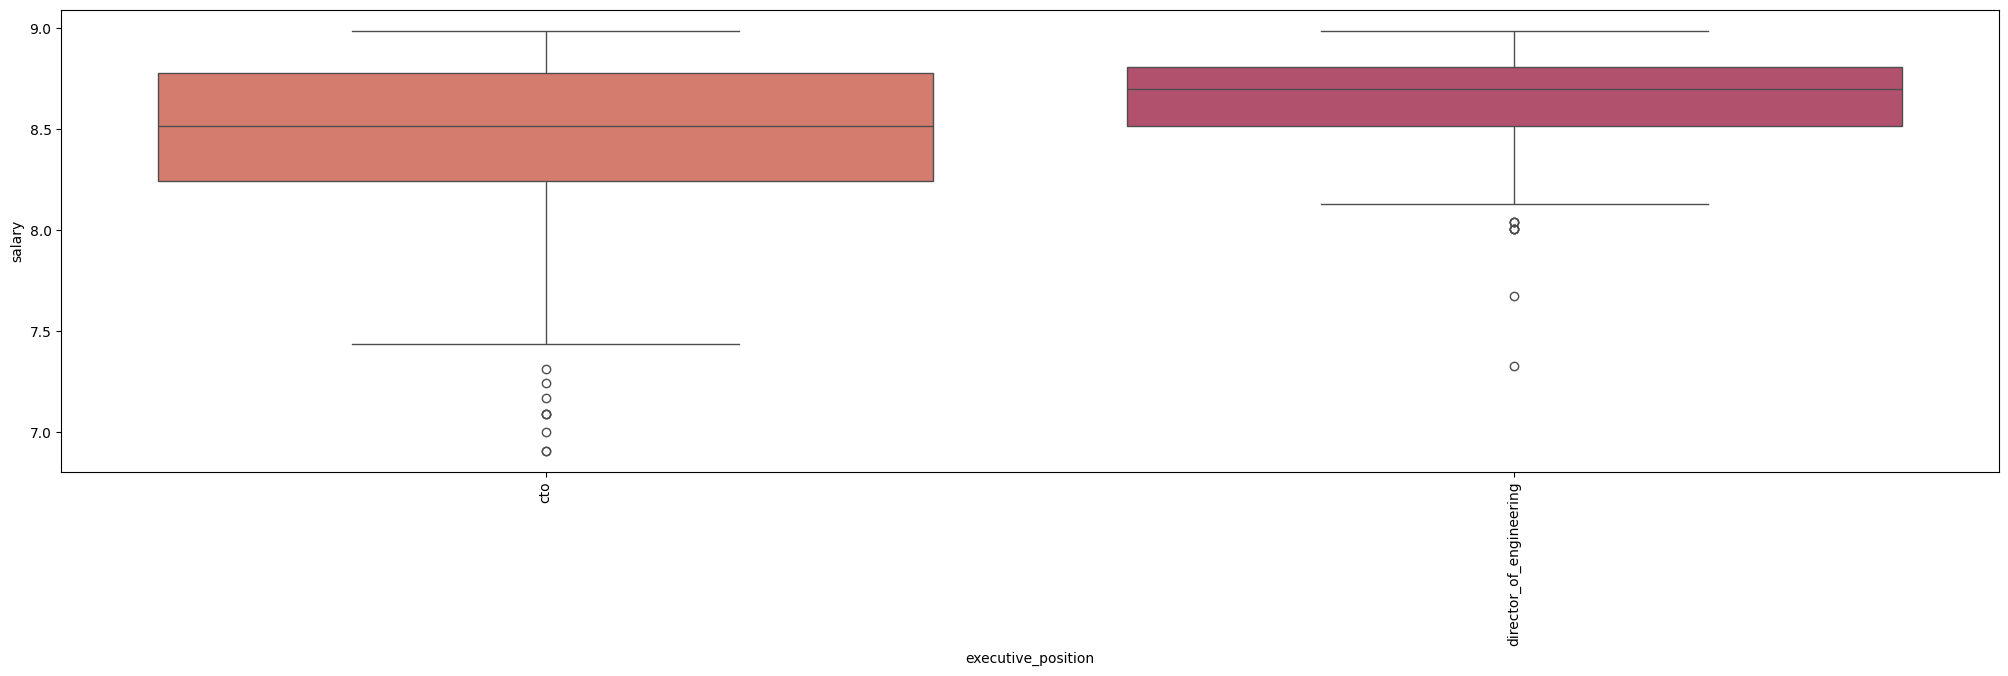

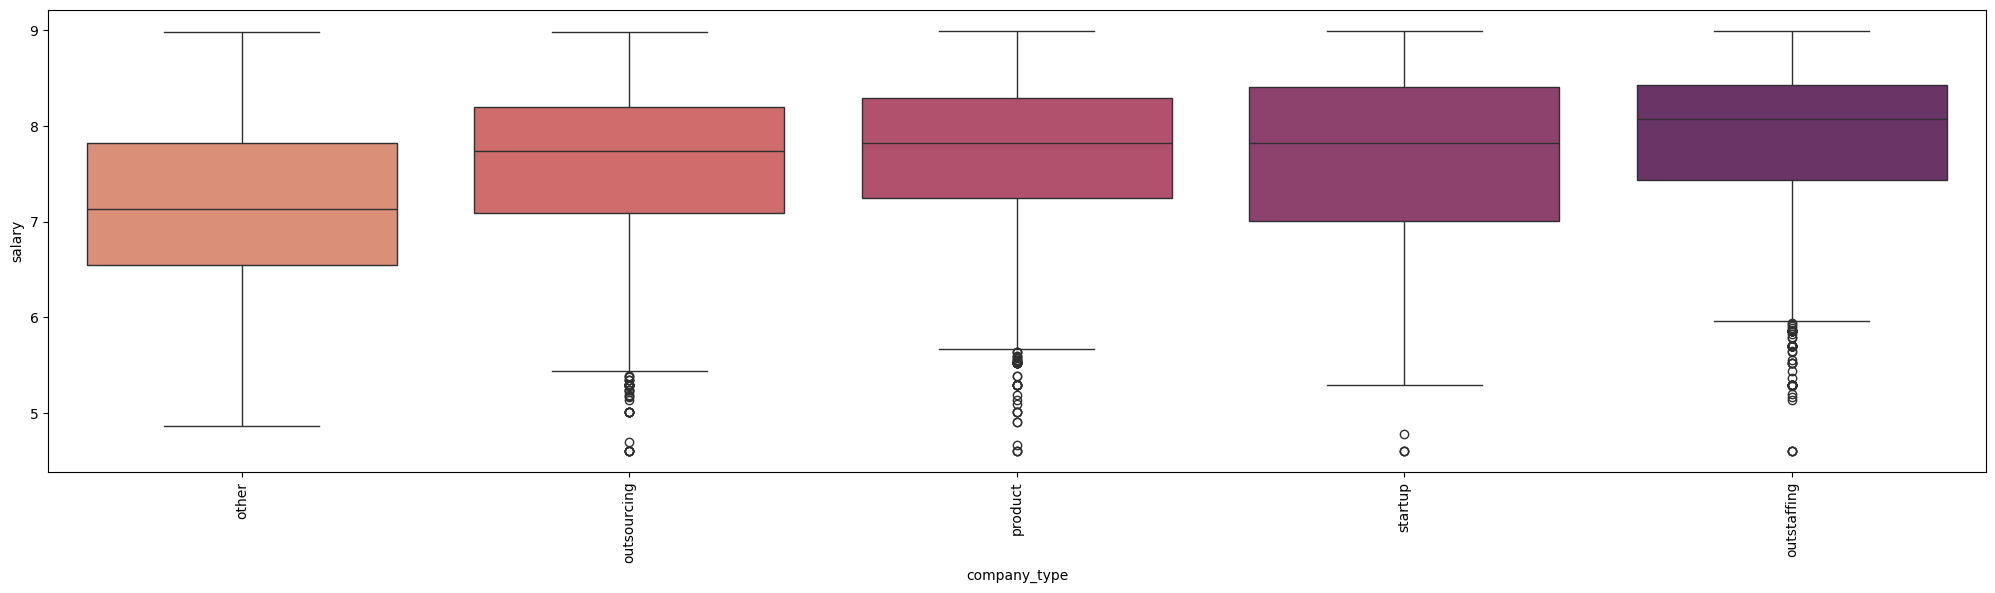

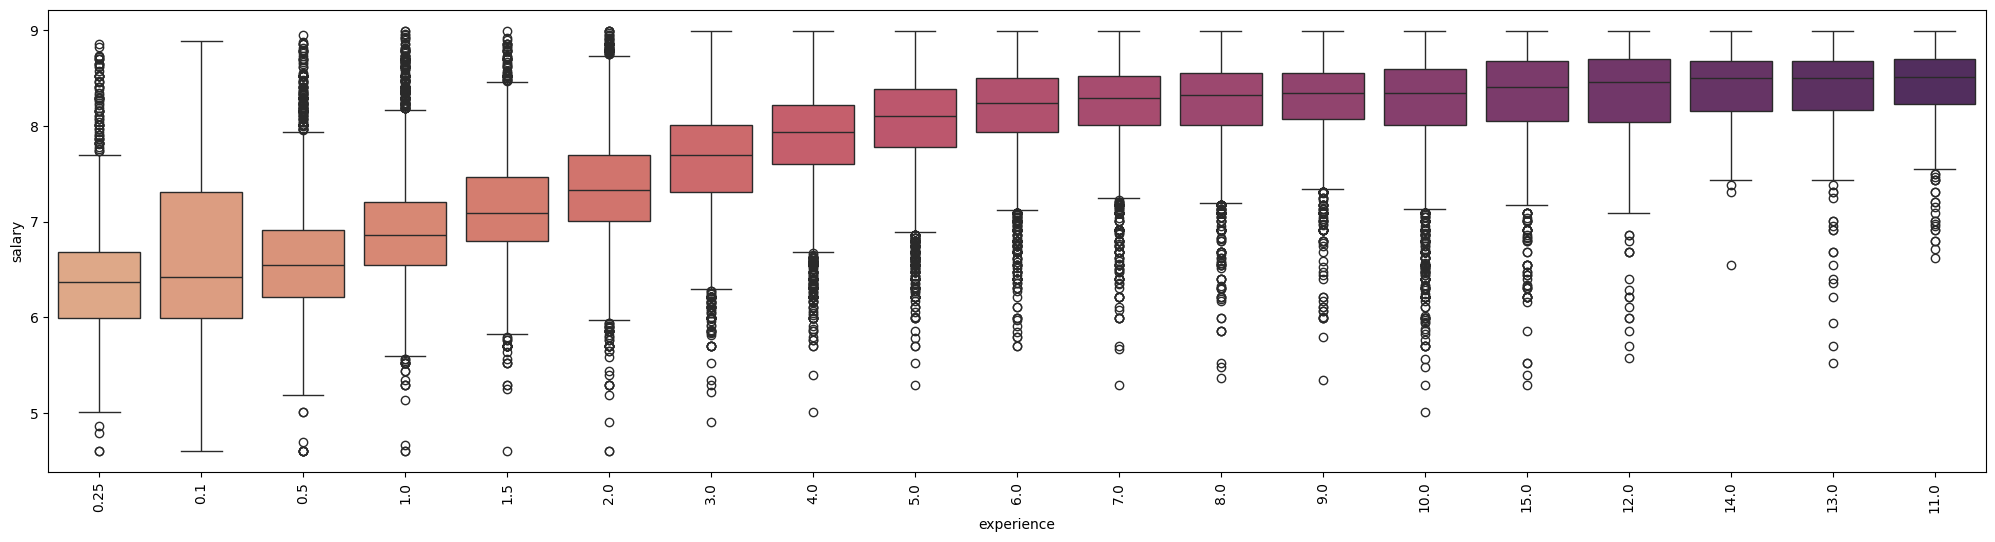

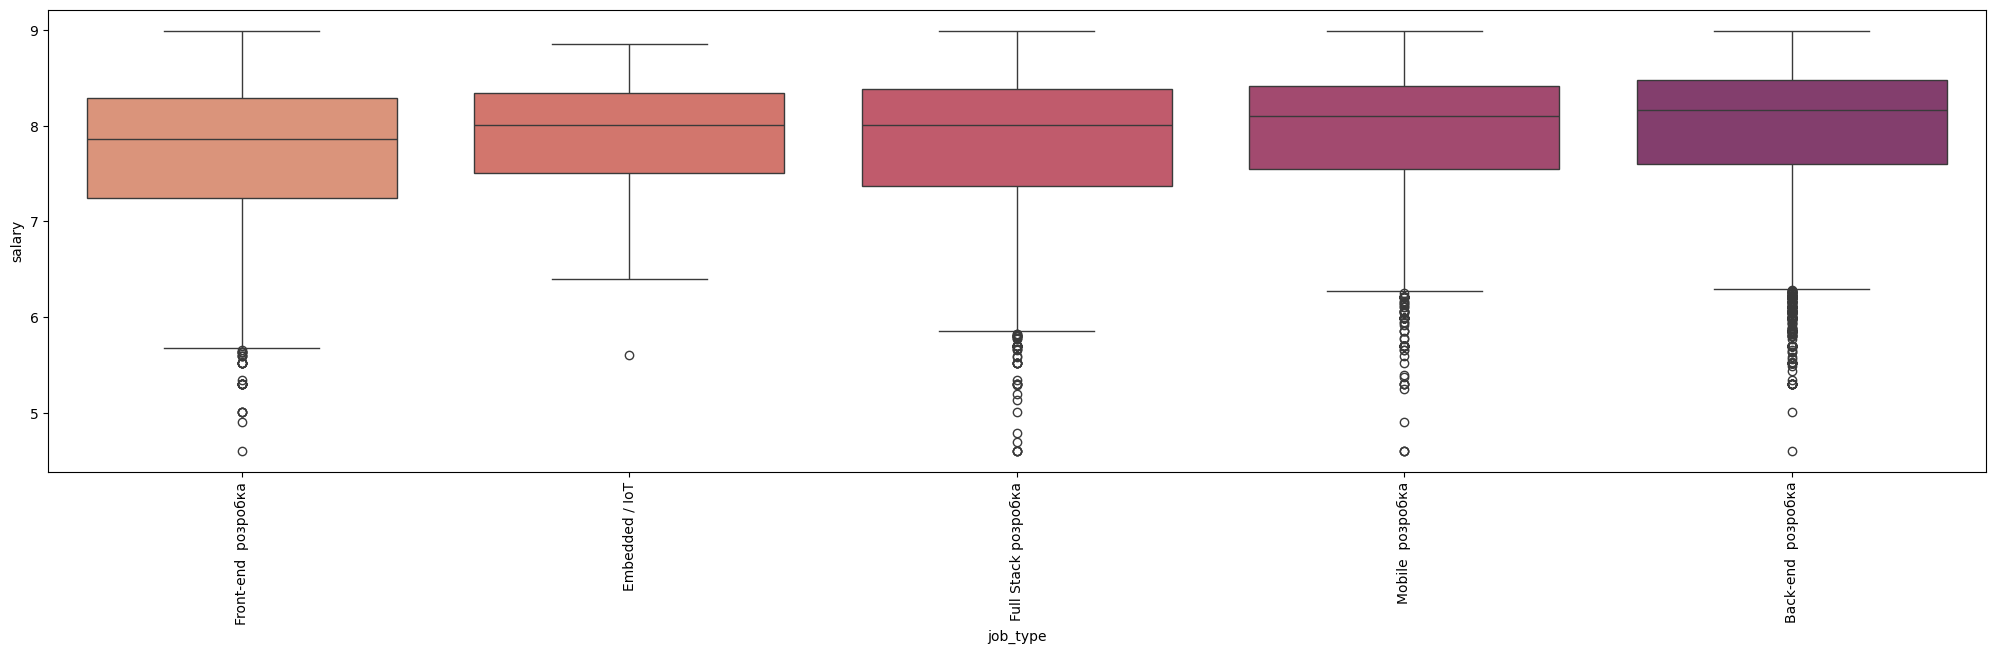

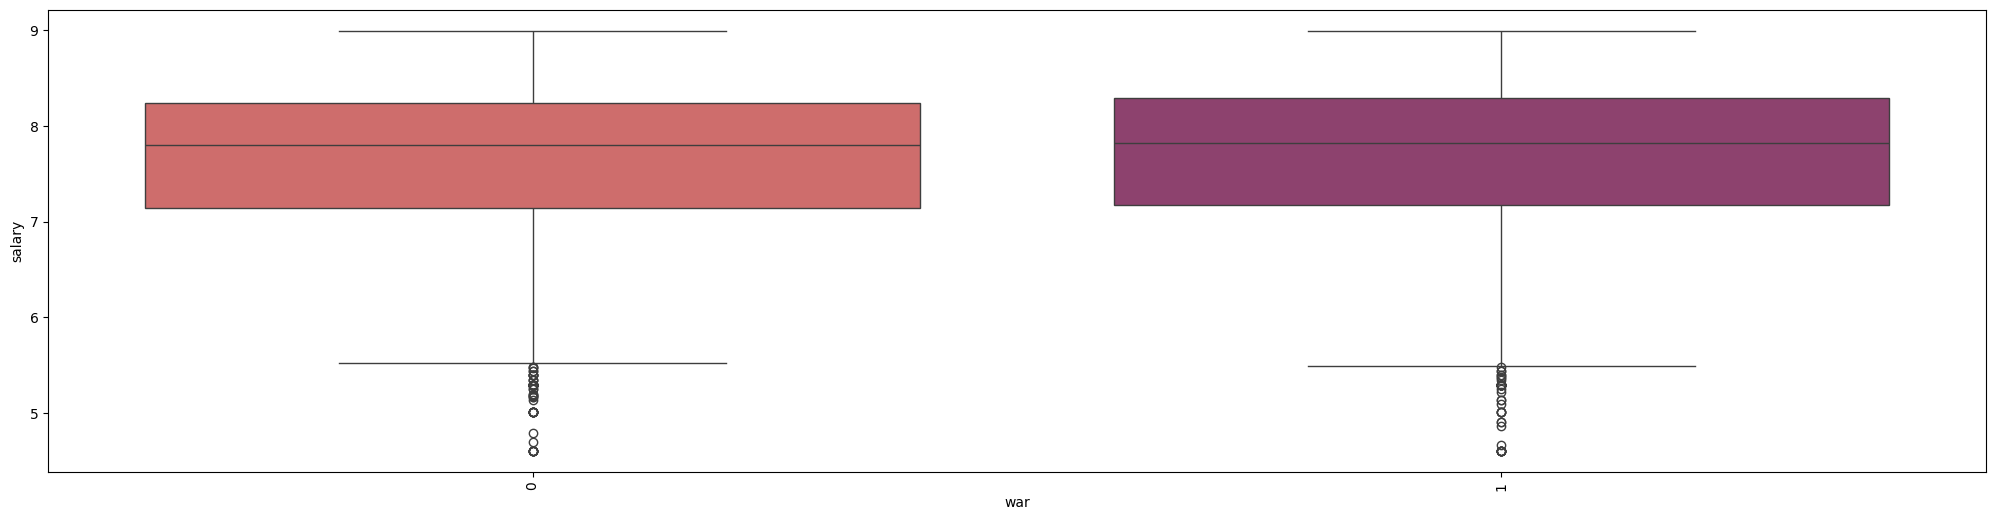

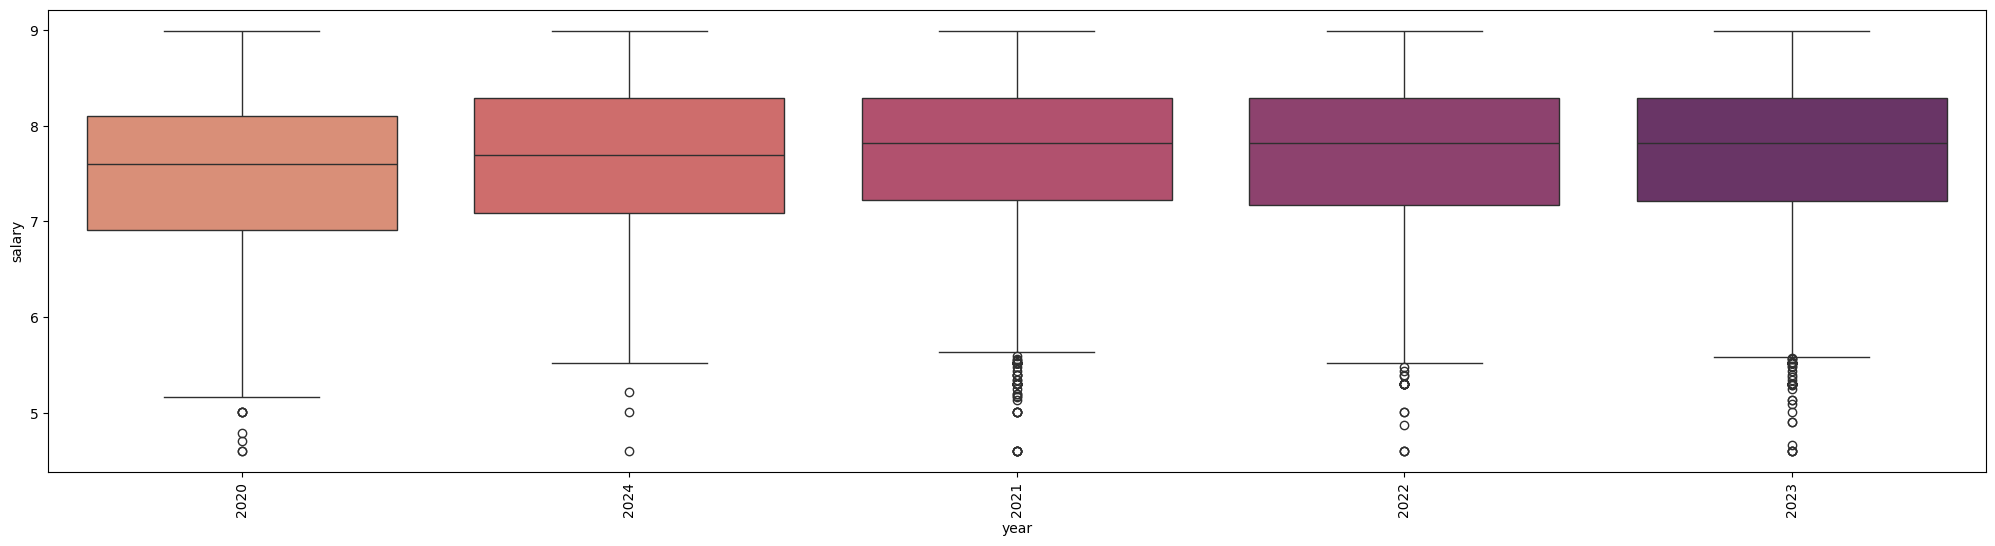

In [21]:
for i in columns:
    if i not in ['log_age','log_experience']:
        salary_dastribution_plot(i)

# OLS

perfrom OLS

In [22]:
regression_columns = ['log_experience',
                      'experience',
  'war',

  'log_age',
  'gender',
  # 'age',


  'job_level_architect',
 'job_level_head',
 'job_level_junior',
 'job_level_manager',
#  'job_level_middle',
#  'job_level_no_title',
 'job_level_senior',
 'job_level_team_lead',
 'job_level_tech_lead',
 'job_level_trainee/intern',

  'english_level_a1',
 'english_level_a2',
#  'english_level_b1',
 'english_level_b2',
 'english_level_c1',


 'education_higher',
  'education_scientific_degree',
  'education_secondary',
  'education_secondary_vocational',
  # 'education_student',


'specialisation_analysis',
 'specialisation_data_science',
 'specialisation_dba',
 'specialisation_design',
 'specialisation_development',
 'specialisation_enterprise_systems',
#  'specialisation_executive',
 'specialisation_hr',
 'specialisation_html',
 'specialisation_management',
 'specialisation_marketing',
 'specialisation_operations',
 'specialisation_programming',
 'specialisation_qa',
 'specialisation_security',
 'specialisation_support',



 'location_Cherkasy',
  'location_Chernihiv',
  'location_Chernivtsi',
  'location_Dnipro',
  'location_Ivano-Frankivsk',
  'location_Kharkiv',
  # 'location_Kherson',
  'location_Khmelnytskyi',
  # 'location_Kropyvnytskyi',
  'location_Kyiv',
  'location_Lutsk',
  'location_Lviv',
  # 'location_Mykolaiv',
  'location_Odesa',
  'location_Poltava',
  'location_Rivne',
  'location_Sumy',
  'location_Ternopil',
  'location_Uzhhorod',
  'location_Vinnytsia',
  # 'location_Zaporizhzhia',
  'location_Zhytomyr',


# 'company_type_other',
  'company_type_outsourcing',
  'company_type_outstaffing',
  'company_type_product',
  'company_type_startup',


'programming_language_1С',
#  'programming_language_C',
 'programming_language_C# / .NET',
#  'programming_language_C++',
 'programming_language_Dart',
 'programming_language_Go',
#  'programming_language_Groovy',
 'programming_language_Java',
 'programming_language_JavaScript',
 'programming_language_Kotlin',
 'programming_language_PHP',
 'programming_language_Python',
 'programming_language_Ruby',
 'programming_language_Rust',
 'programming_language_Scala',
 'programming_language_Swift',
 'programming_language_TypeScript',
 'programming_language_db_languages',
 'programming_language_not_using',
#  'programming_language_other',



#  'qa_position_general',
 'qa_position_manual',
  'qa_position_utomation',



'designer_position_2d_artist',
 'designer_position_3d_artist',
 'designer_position_game_designer',
 'designer_position_graphic/video_designer',
#  'designer_position_product_designer',
 'designer_position_ui/ux_designer',



# 'marketing_position_chief_marketing_officer',
 'marketing_position_copywriter',
 'marketing_position_digital_marketing_manager',
#  'marketing_position_employer_brand_manager',
 'marketing_position_marketing_manager',
 'marketing_position_seo_specialist',



'hr_position_hr_business_partner',
#  'hr_position_hr_director',
 'hr_position_hr_manager',
 'hr_position_people_partner/happiness_manager',
 'hr_position_recruiter',
 'hr_position_talent_acquisition_manager',
 'hr_position_talent_researcher/sourcer',



 'management_position_delivery_manager',
 'management_position_product_manager',
 'management_position_product_owner',
 'management_position_program_manager',
#  'management_position_project_manager',
#  'management_position_sales_manager',
 'management_position_scrum_master',


# 'analyst_position_BI Analyst',
 'analyst_position_Business Analyst',
#  'analyst_position_Data Analyst',
 'analyst_position_Product Analyst',
 'analyst_position_System Analyst',


'data_scientist_position_data/big_data_engineer',
#  'data_scientist_position_data_scientist',
 'data_scientist_position_ml/dl_engineer',


 'devops_position_devops_engineer',
 'devops_position_site_reliability_engineer',
 'devops_position_system_administrator',

#  'executive_position_cto',
 'executive_position_director_of_engineering',



# 'job_type_Back-end  розробка',
 'job_type_Front-end  розробка',
 'job_type_Full Stack розробка',
 'job_type_Mobile  розробка',
# 'job_type_Embedded / IoT',


'sphere_adtech/advertising',
#  'sphere_agriculture',
#  'sphere_ai/machine_learning',
 'sphere_ar/vr',
 'sphere_automotive',
#  'sphere_big_data',
 'sphere_blockchain',
 'sphere_cloud_computing',
#  'sphere_data_science',
 'sphere_dating',
 'sphere_e-commerce',
#  'sphere_edtech/education',
#  'sphere_embedded',
 'sphere_erp',
 'sphere_fintech/banking',
 'sphere_gambling',
 'sphere_gamedev',
#  'sphere_geospatial',
#  'sphere_hardware',
 'sphere_high_load_systems',
#  'sphere_insurance',
#  'sphere_internet_of_things',
#  'sphere_legal',
#  'sphere_logistics',
 'sphere_manufacturing',
#  'sphere_media',
 'sphere_medtech/healthcare',
 'sphere_mobile',
#  'sphere_other',
 'sphere_public_services/government',
 'sphere_real_estate',
#  'sphere_retail',
#  'sphere_robotics',
 'sphere_security',
 'sphere_telecom',
 'sphere_travel',
 'sphere_uberfication'



 ]

# scale features to (0,1) range
min_max_scaler = MinMaxScaler()
min_max_ols_x_scaled = min_max_scaler.fit_transform(x_train_val[regression_columns])

# fit the model
ols_x = sm.add_constant(pd.DataFrame(min_max_ols_x_scaled,columns = x[regression_columns].columns))
ols_model = sm.OLS(y_train_val.reset_index(drop=True), ols_x)
ols_model_results = ols_model.fit()

#get the results
ols_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1423.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        06:44:36   Log-Likelihood:                -20094.
No. Observations:               53456   AIC:                         4.045e+04
Df Residuals:                   53326   BIC:                         4.160e+04
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              6.9554      0.032    220.525      0.000       6.894       7.017
log_experience                                     0.7618      0.018     43.089      0.000       0.727       0.796
experience                                         0.0579      0.016      3.638      0.000       0.027       0.089
war                                                0.0662      0.003     19.719      0.000       0.060       0.073
log_age                                            0.1794      0.014     12.417      0.000       0.151       0.208
gender                                             0.0870      0.004     19.842      0.000       0.078       0.096
job_level_architect                                0.6071      0.016     37.463      0.000       0.575       0.639
job_level_head                                     0.4323      0.017     25.720      0.000       0.399       0.465
job_level_junior                                  -0.6067      0.005   -116.881      0.000      -0.617      -0.597
job_level_manager                                  0.2995      0.014     21.406      0.000       0.272       0.327
job_level_senior                                   0.3970      0.004     90.429      0.000       0.388       0.406
job_level_team_lead                                0.4250      0.007     64.626      0.000       0.412       0.438
job_level_tech_lead                                0.5069      0.009     54.881      0.000       0.489       0.525
job_level_trainee/intern                          -1.0505      0.015    -70.848      0.000      -1.080      -1.021
english_level_a1                                  -0.1978      0.011    -17.543      0.000      -0.220      -0.176
english_level_a2                                  -0.1171      0.005    -21.593      0.000      -0.128      -0.106
english_level_b2                                   0.1120      0.004     30.359      0.000       0.105       0.119
english_level_c1                                   0.1694      0.006     30.313      0.000       0.158       0.180
education_higher                                   0.1305      0.007     19.286      0.000       0.117       0.144
education_scientific_degree                        0.0699      0.015      4.741      0.000       0.041       0.099
education_secondary                                0.1108      0.011     10.298      0.000       0.090       0.132
education_secondary_vocational                     0.1291      0.014      9.220      0.000       0.102       0.157
specialisation_analysis                           -0.7265      0.030    -23.889      0.000      -0.786      -0.667
specialisation_data_science                       -0.4769      0.032    -15.052      0.000   

# Linear Regression

In [23]:
def k_fold_validation_lr(x,y,k=4):
    """
    Performs cross Stratified K-fold validation for Linear Regression and returns mean of metrics
    """

    # find quantiles corresponding to each salary value
    quantiles = np.linspace(0, 1, n_quantiles + 1)
    y_quantiles = np.quantile(y, quantiles)
    y_quantile_labels = np.digitize(y, y_quantiles)

    results = []

    # perform cross validation
    k_fold_5 = StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
    for train_idx, validation_idx in k_fold_5.split(x,y_quantile_labels):

        #devide data to train and validation sets
        x_train = x.iloc[train_idx]
        y_train  = y.iloc[train_idx]

        x_val = x.iloc[validation_idx]
        y_val=  y.iloc[validation_idx]

        #scale features to (0,1) range
        minmax = MinMaxScaler()
        x_train_sclaed = minmax.fit_transform(x_train)
        x_val_scaled = minmax.transform(x_val)

        # fit Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(x_train_sclaed, y_train)

        #predict values
        y_pred_val = lr_model.predict(x_val_scaled)
        #evaluate results
        metrics_val= compute_metrics_dct(np.exp(y_val),np.exp(y_pred_val))

        results.append(list(metrics_val.values()))
    return list(np.mean(results,axis=0)) #mean of the metrics


### LR benchmark model validation

In [24]:
# modifying feature set for benchmark model
x_lr_bench = deepcopy(x)
x_lr_bench['exp2'] = np.square(x_lr_bench['experience'])
x_lr_bench['specialisation_other'] = (x_lr_bench['specialisation_management']==0)&(x_lr_bench['specialisation_programming']==0)&(x_lr_bench['specialisation_qa']==0)
x_train_val_lr_bench, x_test_lr_bench, y_train_val_lr_bench, y_test_lr_bench = train_test_split(x_lr_bench, y, stratify=y_quantile_labels, test_size=0.15, random_state=42)

In [25]:
# banchkmark model validation
benchmark_regression_columns = [
     'exp2',
    'experience',

   'specialisation_management',
 'specialisation_other',
 'specialisation_qa',

   'company_type_other',
  'company_type_outstaffing',
  'company_type_product',
  'company_type_startup',


  'english_level_a1',
 'english_level_a2',
 'english_level_b1',
 'english_level_b2',

]
bemch_mark_lr_results = k_fold_validation_lr(x_train_val_lr_bench[benchmark_regression_columns],y_train_val_lr_bench)
print(bemch_mark_lr_results)

[1580515.9162827556, 1257.1520368943122, 898.7495347881354, 42.23860939170538, 0.4783934940608872]


### Proposed LR validation

In [26]:
# withot engineered feature
regression_columns_2 = deepcopy(regression_columns)
regression_columns_2.append('age')
regression_columns_2.remove('log_age')
regression_columns_2.remove('log_experience')
regression_columns_2.remove('war')

lr_regression_columns = [regression_columns, regression_columns_2]

# perform cross validation on each feature set
for i,cols in enumerate(lr_regression_columns):
    print('REGRESSION',i)
    results = k_fold_validation_lr(x_train_val[cols],y_train_val)
    print(results)

REGRESSION 0
[848943.3880555924, 921.3669415238285, 653.5751466177229, 28.9795696505308, 0.7198292583077623]
REGRESSION 1
[888981.9644137231, 942.8375956084047, 672.1359882433505, 29.948936682571066, 0.7066154587467994]


### LR testing

In [27]:
lr_model = LinearRegression()
lr_model.fit(x_train_val[regression_columns], y_train_val)
y_pred_test = lr_model.predict(x_test[regression_columns])
metrics_test= compute_metrics_dct(np.exp(y_test),np.exp(y_pred_test))
metrics_test

{'MSE': 823956.1514656685,
 'RMSE': 907.720304645472,
 'MAE': 648.6729440265416,
 'MAPE': 29.00570686284339,
 'R2': 0.7278854196305711}

# Random Forest

In [29]:
def k_fold_validation_rf(x,y,k=4,n_estimators=50,max_depth=None,max_features=1, min_samples_split =2,min_samples_leaf =1):
    '''
    Perform Stratified K-Fold validation for Random Forest and returns mean of the metrics
    '''
    # find the corresponding quantile to each value in y
    quantiles = np.linspace(0, 1, n_quantiles + 1)
    y_quantiles = np.quantile(y, quantiles)
    y_quantile_labels = np.digitize(y, y_quantiles)

    #perform cross validation
    k_fold_5 = StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
    results = []
    for train_idx, validation_idx in k_fold_5.split(x,y_quantile_labels):

        # get train values
        x_train = x.iloc[train_idx]
        y_train  = y.iloc[train_idx]

        # get validation values
        x_val = x.iloc[validation_idx]
        y_val=  y.iloc[validation_idx]

        # fit model
        rf_model = RandomForestRegressor(random_state=42,criterion='friedman_mse',n_jobs=-1,n_estimators=n_estimators,
                                         max_depth=max_depth,max_features=max_features, min_samples_split = min_samples_split,min_samples_leaf =min_samples_leaf)
        rf_model.fit(x_train, y_train)


        y_pred_val = rf_model.predict(x_val) # predict values
        metrics_val= compute_metrics_dct(np.exp(y_val),np.exp(y_pred_val)) #evaluatemetrics

        results.append(list(metrics_val.values()))

    return list(np.mean(results,axis=0))


### RF cross validation

In [35]:
# parameters validated
max_features = [1,'sqrt', 40, 60]
n_estimators=[100,300,500]
min_samples_splits = [2,6,10]
max_depth= [100, 1000, 10000, None]

# Cross validation. TAKES LONG TIME! To run again uncomment the code below


# with open('performance/random_forest_results.json', 'w') as f:
#   for estim in n_estimators:
#     for max_f in max_features:
#       for min_samples_split in min_samples_splits:
#             for max_d in max_depth:
#                 time_start = time.time()
#                 results = k_fold_validation_rf(x_train_val,y_train_val,
#                                               k=4,n_estimators=estim,max_depth=max_d,max_features=max_f, min_samples_split =min_samples_split,min_samples_leaf =1)
#                 time_end = time.time()
#                 total_seconds = time_end - time_start
#                 json.dump({'results':results, 'n_estimators':estim,'max_features':max_f,'min_samples_split':min_samples_split,'min_samples_leaf':1,'max_depth':max_d,'time':total_seconds}, f)
#                 f.write('\n')

In [37]:
# read cross validation results
with open('performance/random_forest_results.json', 'r') as f:
    json_data = []
    for i in f:
        json_data.append(json.loads(i))

# make DataFrame of results
rf_models_results_df = pd.DataFrame(json_data)
rf_models_results_df[['mse', 'rmse', 'mae', 'mape','r2']] = pd.DataFrame(rf_models_results_df['results'].tolist(), index=rf_models_results_df.index)
rf_models_results_df.drop(columns='results',inplace=True)
rf_models_results_df.sort_values('rmse')

,n_estimators,max_features,min_samples_split,min_samples_leaf,max_depth,time,mse,rmse,mae,mape,r2
132,500,60,2,1,100.0,574.883893,7.334634e+05,856.407837,602.702348,26.890408,0.758103
133,500,60,2,1,1000.0,566.389306,7.334634e+05,856.407837,602.702348,26.890408,0.758103
135,500,60,2,1,NaN,570.008312,7.334634e+05,856.407837,602.702348,26.890408,0.758103
134,500,60,2,1,10000.0,570.015203,7.334634e+05,856.407837,602.702348,26.890408,0.758103
86,300,60,2,1,10000.0,243.352115,7.350114e+05,857.310878,603.530638,26.932635,0.757592
...,...,...,...,...,...,...,...,...,...,...,...
104,500,1,10,1,100.0,74.612105,1.126451e+06,1061.339033,745.999224,34.212333,0.628488
10,100,1,10,1,10000.0,10.787272,1.133687e+06,1064.740247,748.553334,34.341066,0.626101
11,100,1,10,1,NaN,10.524765,1.133687e+06,1064.740247,748.553334,34.341066,0.626101
9,100,1,10,1,1000.0,10.507273,1.133687e+06,1064.740247,748.553334,34.341066,0.626101


Best model on cross validation

In [33]:
best_rf = rf_models_results_df.sort_values('rmse')[:3]
best_rf

,n_estimators,max_features,min_samples_split,min_samples_leaf,max_depth,time,mse,rmse,mae,mape,r2
132,500,60,2,1,100.0,574.883893,733463.430489,856.407837,602.702348,26.890408,0.758103
133,500,60,2,1,1000.0,566.389306,733463.430489,856.407837,602.702348,26.890408,0.758103
135,500,60,2,1,NaN,570.008312,733463.430489,856.407837,602.702348,26.890408,0.758103


### RF additional cross validation

In [40]:
# parameters validated

n_estimators = [500,700,1500]
max_features=[50,60,70,80]
min_samples_splits = [2]
max_depth= [None]

# Additional cross validation. TAKES LONG TIME! To run again uncomment the code below

# with open('performance/random_forest_results_additional.json', 'w') as f:
#   for estim in n_estimators:
#     for max_f in max_features:
#       for min_samples_split in min_samples_splits:
#             for max_d in max_depth:
#
#                   print({'n_estimators':estim,'max_features':max_f,'min_samples_split':min_samples_split,'min_samples_leaf':1,'max_depth':max_d})
#                   time_start = time.time()
#                   results = k_fold_validation_rf(x_train_val,y_train_val,
#                                                 k=4,n_estimators=estim,max_depth=max_d,max_features=max_f, min_samples_split =min_samples_split,min_samples_leaf =1)
#                   time_end = time.time()
#                   total_seconds = time_end - time_start

#                   json.dump({'results':results, 'n_estimators':estim,'max_features':max_f,'min_samples_split':min_samples_split,'min_samples_leaf':1,'max_depth':max_d,'time':total_seconds}, f)
#                   f.write('\n')


In [41]:
# read additional cross validation results
with open('performance/random_forest_results_additional.json', 'r') as f:
    json_data = []
    for i in f:
        json_data.append(json.loads(i))

# make DataFrame of results
additional_rf_val_df = pd.DataFrame(json_data)
additional_rf_val_df[['MSE', 'RMSE', 'MAE', 'MAPE','R2']] = pd.DataFrame(additional_rf_val_df['results'].tolist(), index=additional_rf_val_df.index)
additional_rf_val_df.drop(columns='results',inplace=True)
additional_rf_val_df['time'] = additional_rf_val_df['time']/4 # get mean time of training
additional_rf_val_df['R2'] = additional_rf_val_df['R2']*100

additional_rf_val_df.sort_values('RMSE')

,n_estimators,max_features,min_samples_split,min_samples_leaf,max_depth,time,MSE,RMSE,MAE,MAPE,R2
10,1500,70,2,1,None,181.184344,732607.690069,855.906638,602.427622,26.879771,75.838538
9,1500,60,2,1,None,182.090152,732625.536116,855.918989,602.250207,26.868360,75.837924
5,700,60,2,1,None,85.023380,733072.957784,856.180179,602.552205,26.880865,75.823176
6,700,70,2,1,None,100.992848,733286.790176,856.302585,602.696713,26.895814,75.816148
8,1500,50,2,1,None,170.837153,733300.861401,856.317322,602.236570,26.868844,75.815608
11,1500,80,2,1,None,211.060729,733432.858832,856.385953,602.598867,26.877179,75.811348
1,500,60,2,1,None,66.608850,733474.993054,856.414391,602.718920,26.892231,75.809922
4,700,50,2,1,None,76.344286,733956.196626,856.700292,602.508167,26.883317,75.793996
2,500,70,2,1,None,77.866270,734197.573076,856.833944,603.078570,26.911962,75.786112
7,700,80,2,1,None,119.864219,734277.318028,856.877522,603.062614,26.894797,75.783509


### RF addition validation performance visualization

Additional cross-validation Random Forest results visualization

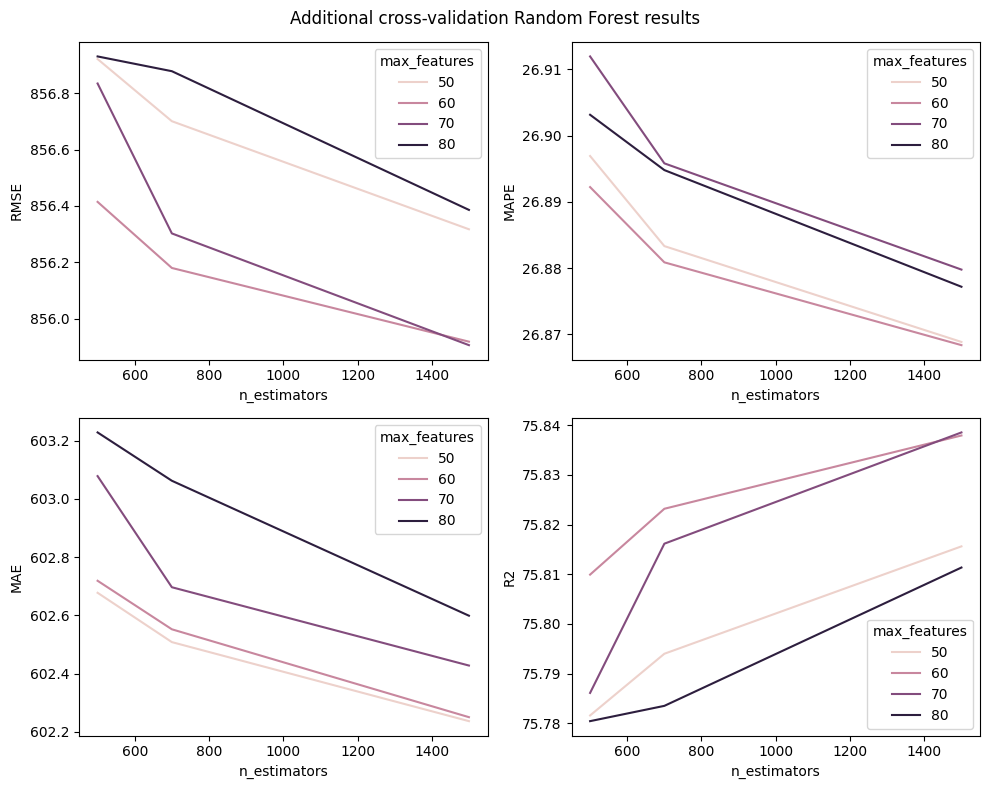

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.lineplot(data=additional_rf_val_df, x='n_estimators', y='RMSE', hue='max_features',ax=axes[0,0])
sns.lineplot(data=additional_rf_val_df, x='n_estimators', y='MAPE', hue='max_features',ax=axes[0,1])
sns.lineplot(data=additional_rf_val_df, x='n_estimators', y='MAE', hue='max_features',ax=axes[1,0])
sns.lineplot(data=additional_rf_val_df, x='n_estimators', y='R2', hue='max_features',ax=axes[1,1])
plt.suptitle('Additional cross-validation Random Forest results')
plt.tight_layout()
plt.show()

Additional cross-validation Random Forest training time visualization

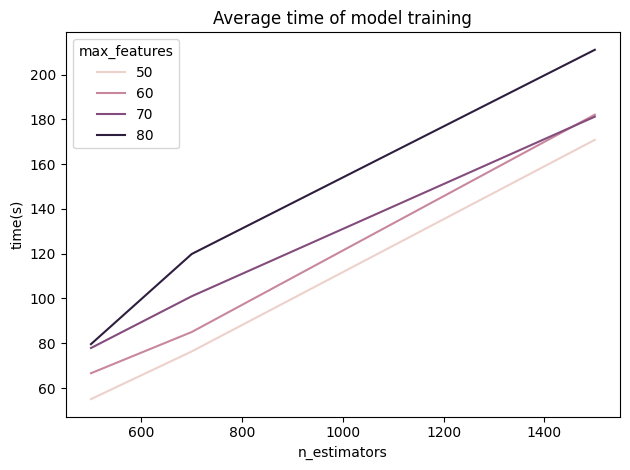

In [38]:
sns.lineplot(data=additional_rf_val_df, x='n_estimators', y='time', hue='max_features')
plt.title('Average time of model training')
plt.tight_layout()
plt.ylabel('time(s)')
plt.show()

### RF test

In [62]:
rf_model = RandomForestRegressor(random_state=42,criterion='friedman_mse',n_jobs=-1,n_estimators=500,
                                         max_depth=None,max_features=60, min_samples_split = 2,min_samples_leaf =1)
rf_model.fit(x_train_val, y_train_val)
y_pred_val = rf_model.predict(x_test) # predict values
metrics_val= compute_metrics_dct(np.exp(y_test),np.exp(y_pred_val)) #evaluatemetrics
list(metrics_val.values())

[687260.2966602001,
 829.0116384347086,
 588.6799254471784,
 26.590133734440148,
 0.7730297335633742]

# Neural Networks

Functions for models creation

In [40]:

def create_model_1():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

def create_model_2():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

def create_model_3():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
def create_model_4():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

def create_model_5():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

def create_model_6():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
def create_model_7():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(16, activation='sigmoid'),
     tf.keras.layers.Dense(1, activation='sigmoid'),

])
def create_model_8():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(16, activation='sigmoid'),
     tf.keras.layers.Dense(1, activation='sigmoid'),

])

In [41]:
# dictionaty for easier model creation
models_dct = {
    '1': create_model_1,
    '2': create_model_2,
    '3': create_model_3,
    '4': create_model_4,
    '5': create_model_5,
    '6': create_model_6,
    '7': create_model_7,
    '8': create_model_8,

}

In [42]:


def k_fold_validation_val_0(model_fn,x,y,epochs=50,batch_size=128,loss='mse',k=4,n_quantiles=100):
    '''
    Perform Stratified K-Fold validation for Neural Network and returns mean metrics, loss, and validation loss
    '''
    # find the corresponding quantile to each value in y
    quantiles = np.linspace(0, 1, n_quantiles + 1)
    y_quantiles = np.quantile(y, quantiles)
    y_quantile_labels = np.digitize(y, y_quantiles)

    metrics_results = []
    losses = []
    val_losses = []

    #perform cross validation
    k_fold_5 = StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
    for train_idx, validation_idx in k_fold_5.split(x,y_quantile_labels):

        # get train values
        x_train = x.iloc[train_idx]
        y_train  = y.iloc[train_idx]

        # get validation values
        x_val = x.iloc[validation_idx]
        y_val=  y.iloc[validation_idx]

        # scale features and y
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()

        x_train_scaled= scaler_x.fit_transform(x_train)
        x_val_scaled= scaler_x.transform(x_val)

        y_train_scaled = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))
        y_val_scaled= scaler_y.transform(np.array(y_val).reshape(-1, 1))

        #train model
        nn_model = model_fn()
        nn_model.compile(optimizer= tf.keras.optimizers.Adam(), loss=loss)
        history = nn_model.fit(x_train_scaled, y_train_scaled,epochs=epochs, batch_size=batch_size,validation_data = (x_val_scaled,y_val_scaled),verbose=0)

        y_pred_val = nn_model.predict(x_val_scaled) # predict values
        metrics_val= compute_metrics_dct(np.exp(y_val),np.exp(scaler_y.inverse_transform(y_pred_val))) #evaluate metrics

        metrics_results.append(list(metrics_val.values()))
        losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

    #mean metrics, loss, and validation loss
    return {'metrics': list(np.mean(metrics_results,axis=0)),'loss' : list(np.mean(losses,axis=0)), 'val_loss' : list(np.mean(val_losses,axis=0))}

### Benchmark NN

In [55]:
def create_model_0():
    return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(x.columns),)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
     tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
create_model_0().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 525       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 531 (2.07 KB)
Trainable params: 531 (2.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
#parameters validated
batch_sizes = [32,64,128,256,512]
epochs_num = [20,50,100,150,200]

# Additional cross validation. TAKES LONG TIME! To run again uncomment the code below


# with open('performance/benchmark_model_results.json', 'w') as f:
#     for batch_size in batch_sizes:
#         for epoch in epochs_num:
#             res  = k_fold_validation_val_0(create_model_0,x_train_val,y_train_val,epochs=epoch,batch_size=batch_size)
#             res.update({'batch_size':batch_size,'epochs':epoch})
#             json.dump(res, f)
#             f.write('\n')

In [31]:
with open('performance/benchmark_model_results.json', 'r') as f:
    json_data = []
    for i in f:
        json_data.append(json.loads(i))
benchmark_model_results_df = pd.DataFrame(json_data)
benchmark_model_results_df[['MSE', 'RMSE', 'MAE', 'MAPE','R2']] = pd.DataFrame(benchmark_model_results_df['metrics'].tolist(), index=benchmark_model_results_df.index)
benchmark_model_results_df.drop(columns='metrics',inplace=True)
benchmark_model_results_df.sort_values('RMSE')

,loss,val_loss,batch_size,epochs,MSE,RMSE,MAE,MAPE,R2
4,"[0.03975523170083761, 0.019950593821704388, 0....","[0.02844670508056879, 0.014928312739357352, 0....",32,200,7.704796e+05,877.734797,622.397872,26.967280,0.745896
8,"[0.05307693965733051, 0.033166041132062674, 0....","[0.038995189126580954, 0.028486504685133696, 0...",64,150,7.718996e+05,878.563023,626.014705,27.416204,0.745425
3,"[0.03721762262284756, 0.017161417054012418, 0....","[0.023668856360018253, 0.013631213922053576, 0...",32,150,7.752588e+05,880.453114,625.029594,27.103428,0.744320
13,"[0.06895275972783566, 0.045945797115564346, 0....","[0.05201147589832544, 0.041231864131987095, 0....",128,150,7.801775e+05,883.243073,629.549340,27.662257,0.742694
19,"[0.06883959006518126, 0.05408970545977354, 0.0...","[0.05925522651523352, 0.049807692877948284, 0....",256,200,7.812151e+05,883.838332,630.177551,27.664608,0.742355
2,"[0.04912103060632944, 0.024715096224099398, 0....","[0.03616062551736832, 0.016886833356693387, 0....",32,100,7.812752e+05,883.850497,629.930566,27.613840,0.742335
14,"[0.05598693620413542, 0.042047238908708096, 0....","[0.04670869838446379, 0.03787290584295988, 0.0...",128,200,7.814343e+05,883.950095,629.035222,27.442774,0.742281
9,"[0.057227165438234806, 0.039210520684719086, 0...","[0.044674769975245, 0.0329046119004488, 0.0212...",64,200,7.815734e+05,884.023501,628.167313,27.375480,0.742236
12,"[0.05026768799871206, 0.038326792884618044, 0....","[0.04287002328783274, 0.03417517989873886, 0.0...",128,100,7.827940e+05,884.711889,630.768771,27.680160,0.741835
24,"[0.07049180846661329, 0.05960882734507322, 0.0...","[0.06388411112129688, 0.05593199469149113, 0.0...",512,200,7.835360e+05,885.158136,632.114098,27.964326,0.741588


Plot best benchmark model loss curves

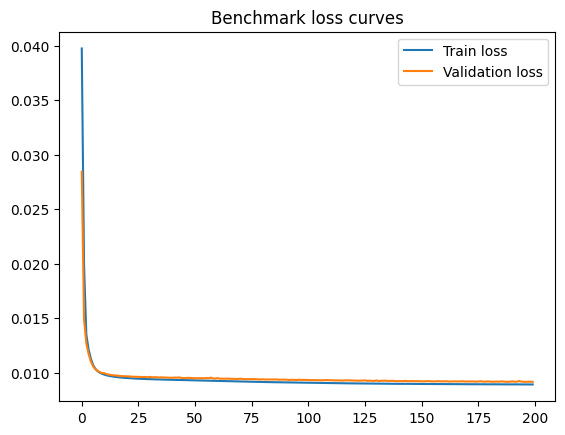

In [45]:
best_benchmark = benchmark_model_results_df.sort_values('RMSE')[:1]
best_benchmark_loss = best_benchmark['loss'].to_numpy()[0]
best_benchmark_val_loss = best_benchmark['val_loss'].to_numpy()[0]
sns.lineplot(y = best_benchmark_loss,x=range(len(best_benchmark_loss)),label= 'Train loss')
sns.lineplot(y = best_benchmark_val_loss,x=range(len(best_benchmark_val_loss)), label= 'Validation loss')

plt.title('Benchmark loss curves')
plt.show()

Visualize benchmark model performance depending on batch size and epochs

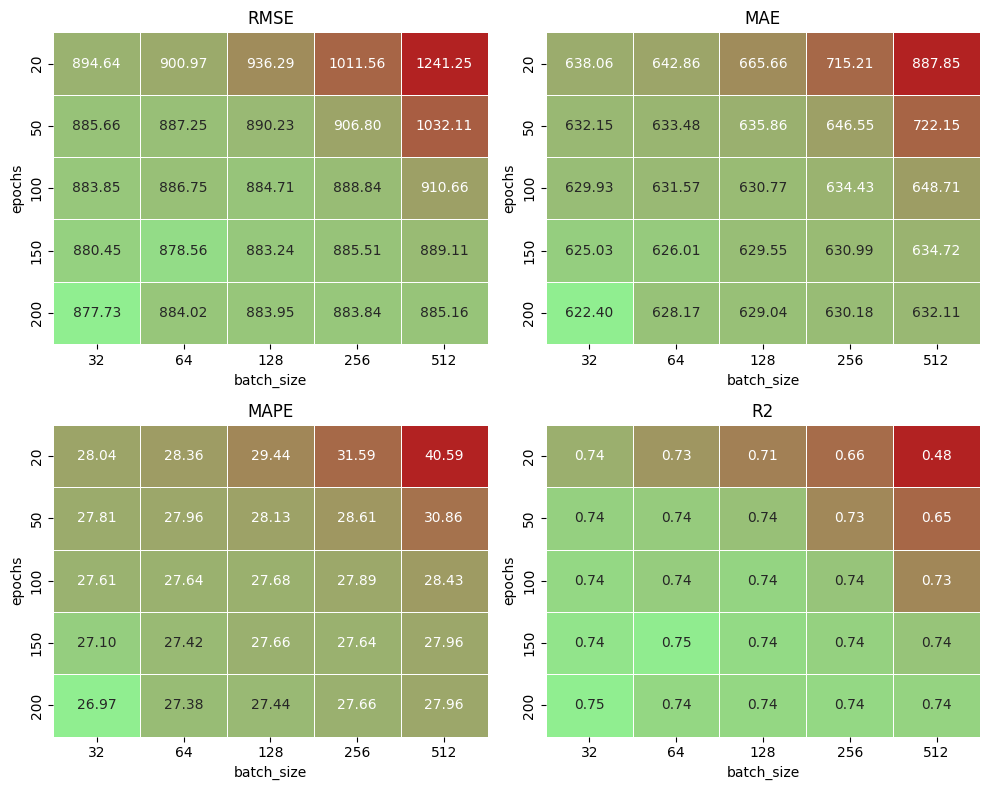

In [46]:
colors = ['lightgreen', 'firebrick']
cmap = LinearSegmentedColormap.from_list('custom', colors)
metric_columns_names = [ 'RMSE', 'MAE', 'MAPE','R2']
rows_num = 2
cols_num = 2
fig, axes = plt.subplots(2,2,figsize=(10, 8))
k = 0

for i in range(rows_num):
    for j in range(cols_num):
        if k!= 3:
            colors = ['lightgreen', 'firebrick']
            norm=PowerNorm(0.4)
        else:
            colors = ['firebrick','lightgreen']
            norm= TwoSlopeNorm(vcenter=0.73)
        cmap = LinearSegmentedColormap.from_list('custom', colors)
        df_pivot = benchmark_model_results_df.pivot_table(index='epochs', columns='batch_size', values=metric_columns_names[k])
        sns.heatmap(df_pivot, cmap=cmap, annot=True, fmt=".2f", linewidths=.5, norm=norm,ax=axes[i,j],cbar=False)
        axes[i,j].set_title(metric_columns_names[k].upper())
        k+=1
plt.tight_layout()
plt.show()

### Proposed NN model

To run cross validation again, uncomment code.

### ATTENTION: IT WILL TAKE A FEW HOURS

In [47]:
#parameters validated

batch_sizes = [32,64,128,256]
epochs_num = [100,150]

# with open('performance/nn_models_results.json', 'w') as f:
#     for num, func in models_dct.items():
#         for batch_size in batch_sizes:
#             for epoch in epochs_num:
#                 if epoch==150 and batch_size not in (128,256):
#                     pass
#                 else:
#                     res  = k_fold_validation_val_0(func,x_train_val,y_train_val,epochs=epoch,batch_size=batch_size)
#                     res.update({'batch_size':batch_size,'epochs':epoch,'model':num})
#                     json.dump(res, f)
#                     f.write('\n')



In [20]:
with open('performance/nn_models_results.json', 'r') as f:
    json_data = []
    for i in f:
        json_data.append(json.loads(i))
nn_models_results_df = pd.DataFrame(json_data)
nn_models_results_df[['MSE', 'RMSE', 'MAE', 'MAPE','R2']] = pd.DataFrame(nn_models_results_df['metrics'].tolist(), index=nn_models_results_df.index)
nn_models_results_df['R2'] = nn_models_results_df['R2']*100
nn_models_results_df['loss_diff'] = [np.mean([abs(b - a) for a, b in zip(lst1, lst2)]) for lst1, lst2 in zip(nn_models_results_df['loss'], nn_models_results_df['val_loss'])]
nn_models_results_df.drop(columns='metrics',inplace=True)
nn_models_results_df.sort_values('R2')[:27]

,loss,val_loss,batch_size,epochs,model,MSE,RMSE,MAE,MAPE,R2,loss_diff
40,"[0.014220999320968986, 0.010384572902694345, 0...","[0.010468416148796678, 0.010313464794307947, 0...",32,100,1,780449.634222,883.403737,627.152824,27.255709,74.260221,0.001341
13,"[0.041568160988390446, 0.023221292532980442, 0...","[0.025974225718528032, 0.013864496257156134, 0...",256,100,7,757892.921350,870.561847,618.927789,27.108795,75.004379,0.000836
7,"[0.0458404840901494, 0.03400719817727804, 0.02...","[0.03740014182403684, 0.028608265332877636, 0....",256,100,4,755347.427024,869.094725,617.997676,27.013573,75.088501,0.000513
9,"[0.05087772663682699, 0.03708665072917938, 0.0...","[0.03941302374005318, 0.032812562538310885, 0....",256,100,5,753319.064844,867.907431,616.745601,26.969215,75.155528,0.000559
44,"[0.026943840086460114, 0.012894642073661089, 0...","[0.014459259575232863, 0.011237892555072904, 0...",32,100,2,748141.168933,864.921552,614.813503,26.966126,75.326248,0.001261
1,"[0.03246644651517272, 0.01389964111149311, 0.0...","[0.017247681505978107, 0.011937158880755305, 0...",256,100,1,747881.263107,864.746512,613.815835,26.695189,75.334890,0.000362
15,"[0.038199443370103836, 0.019793073181062937, 0...","[0.01980752870440483, 0.01287061208859086, 0.0...",256,100,8,747357.240870,864.479805,613.803712,26.833539,75.352099,0.000655
16,"[0.021102057304233313, 0.010898983804509044, 0...","[0.011816117446869612, 0.01050181407481432, 0....",128,150,1,747225.689697,864.393192,613.705777,26.598191,75.356307,0.000806
34,"[0.01636993046849966, 0.010417145909741521, 0....","[0.010668482165783644, 0.0102911158464849, 0.0...",64,100,1,746010.053234,863.684389,613.733498,26.695940,75.396492,0.000769
29,"[0.040521908551454544, 0.022472486831247807, 0...","[0.024172842036932707, 0.013563991524279118, 0...",256,150,7,744508.557450,862.834924,611.875936,26.573995,75.445986,0.000576


In [49]:
best_loss_diff_models = nn_models_results_df.sort_values('loss_diff')[:27]
best_loss_diff_models

,loss,val_loss,batch_size,epochs,model,MSE,RMSE,MAE,MAPE,R2,loss_diff
1,"[0.03246644651517272, 0.01389964111149311, 0.0...","[0.017247681505978107, 0.011937158880755305, 0...",256,100,1,747881.263107,864.746512,613.815835,26.695189,75.334890,0.000362
23,"[0.05950344353914261, 0.045620009768754244, 0....","[0.0493741100654006, 0.0409591575153172, 0.032...",256,150,4,741515.126503,861.059942,611.727152,26.697916,75.545065,0.000430
47,"[0.02701625134795904, 0.014370313379913568, 0....","[0.014124953420832753, 0.011868466157466173, 0...",64,100,4,733168.285298,856.224586,608.074683,26.592865,75.820125,0.000435
3,"[0.04945921804755926, 0.03694218723103404, 0.0...","[0.041595029179006815, 0.032039643032476306, 0...",256,100,2,737238.974254,858.625041,609.739086,26.622131,75.685508,0.000440
22,"[0.05387423560023308, 0.038072926457971334, 0....","[0.04282105294987559, 0.03027589456178248, 0.0...",128,150,4,734439.393099,856.975843,608.678062,26.551092,75.778131,0.000444
8,"[0.03169554425403476, 0.017538344021886587, 0....","[0.018427719362080097, 0.013682968216016889, 0...",128,100,5,733007.024433,856.141090,608.057729,26.688003,75.825348,0.000449
17,"[0.02782365819439292, 0.013256054138764739, 0....","[0.016187570756301284, 0.011560061713680625, 0...",256,150,1,724757.271848,851.289159,606.624500,26.838032,76.097613,0.000456
5,"[0.05130696576088667, 0.03619646979495883, 0.0...","[0.04003488551825285, 0.03206048090942204, 0.0...",256,100,3,741398.039412,861.003107,611.968562,26.786353,75.548748,0.000457
36,"[0.02591530978679657, 0.0142097610514611, 0.01...","[0.012071848614141345, 0.011023091152310371, 0...",64,100,7,732920.969036,856.077020,607.186588,26.475169,75.828226,0.000459
6,"[0.04427093733102083, 0.02640886139124632, 0.0...","[0.030146748758852482, 0.021221685223281384, 0...",128,100,4,739693.831716,860.046266,611.264701,26.752255,75.604703,0.000470


8


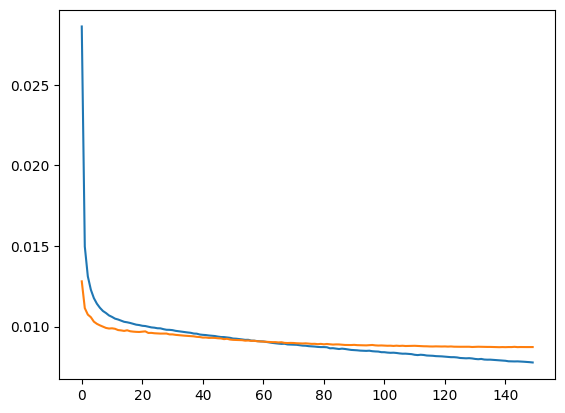

8


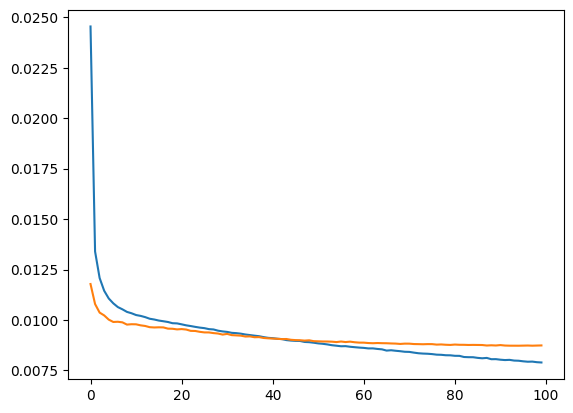

1


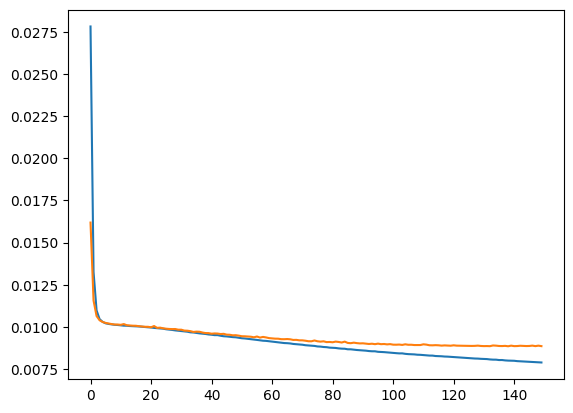

7


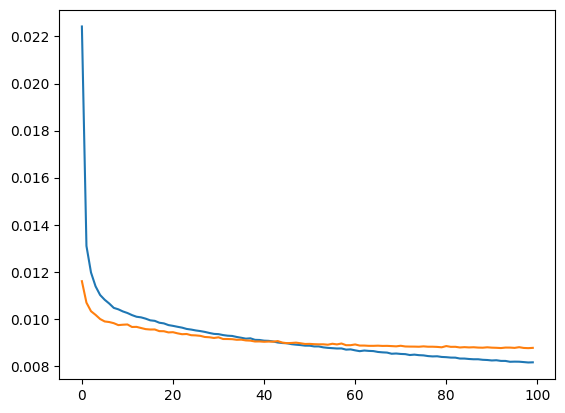

5


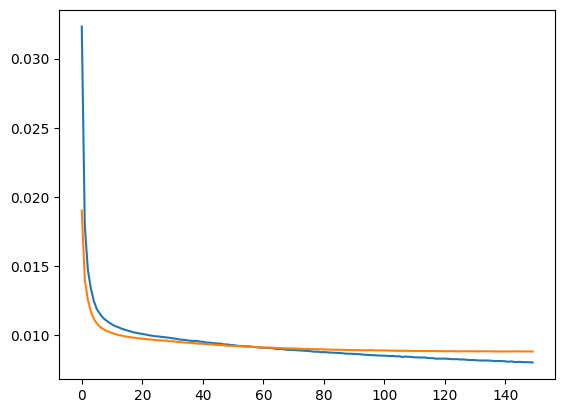

7


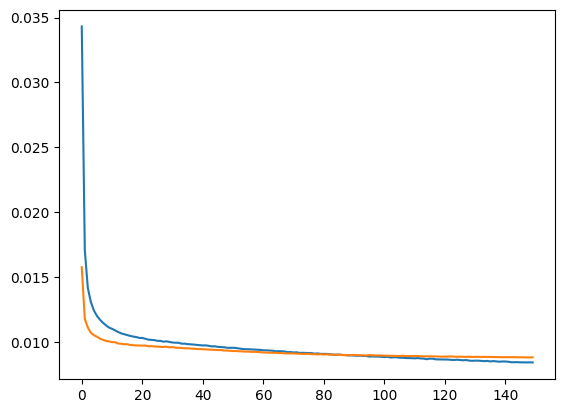

6


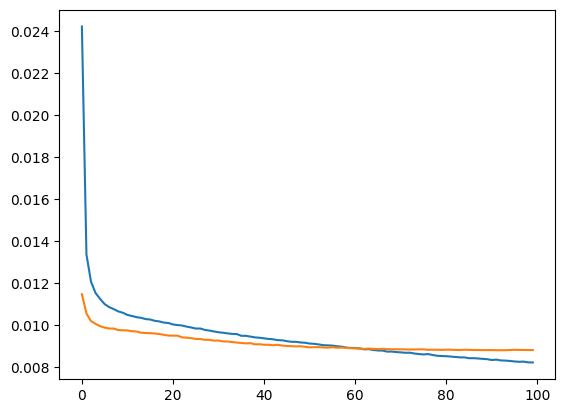

5


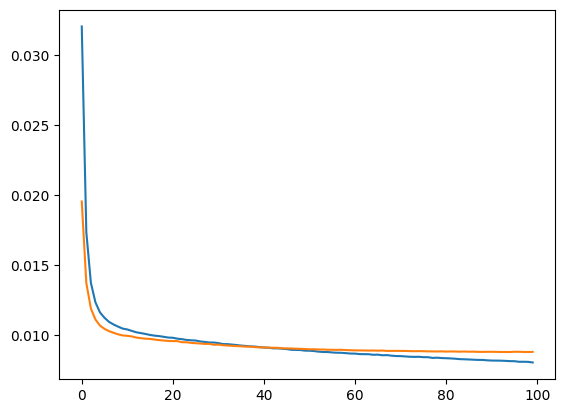

8


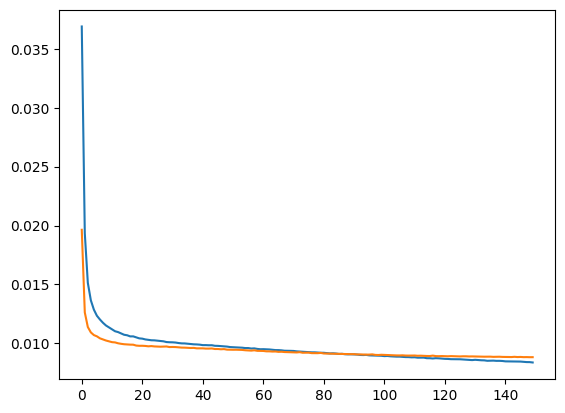

3


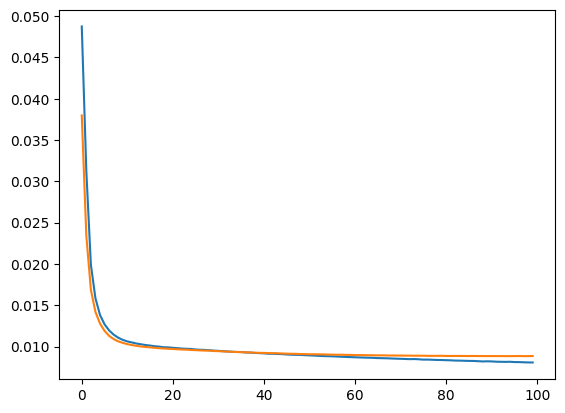

In [50]:
top_10 = best_loss_diff_models.sort_values('RMSE')[:10]
for model,losses in zip(top_10['model'],zip(top_10['loss'],top_10['val_loss'])):
    print(model)
    loss,val_loss = losses
    plt.plot(loss)
    plt.plot(val_loss)
    plt.show()

Find best models

In [51]:
rmse_best = nn_models_results_df.sort_values('RMSE')[:1]
best_tradeoff = best_loss_diff_models.sort_values('RMSE')[9:10]
best_loss = best_loss_diff_models[1:2]
benchmark_best = benchmark_model_results_df.sort_values('RMSE')[:1]
benchmark_best['model'] = 'benchmark'
best_nns_df = pd.concat([rmse_best,best_tradeoff,best_loss,benchmark_best])
best_nns_df

,loss,val_loss,batch_size,epochs,model,MSE,RMSE,MAE,MAPE,R2,loss_diff
30,"[0.0286305476911366, 0.01496942387893796, 0.01...","[0.01280506863258779, 0.011142917908728123, 0....",128,150,8,716626.521891,846.524293,601.613031,26.419423,76.365567,0.000566
4,"[0.04874183051288128, 0.03124593198299408, 0.0...","[0.037974380888044834, 0.023411757312715054, 0...",128,100,3,730941.255261,854.943617,606.909079,26.492015,75.893273,0.000543
23,"[0.05950344353914261, 0.045620009768754244, 0....","[0.0493741100654006, 0.0409591575153172, 0.032...",256,150,4,741515.126503,861.059942,611.727152,26.697916,75.545065,0.000430
4,"[0.03975523170083761, 0.019950593821704388, 0....","[0.02844670508056879, 0.014928312739357352, 0....",32,200,benchmark,770479.617077,877.734797,622.397872,26.967280,0.745896,NaN


Visualize loss curves of best models

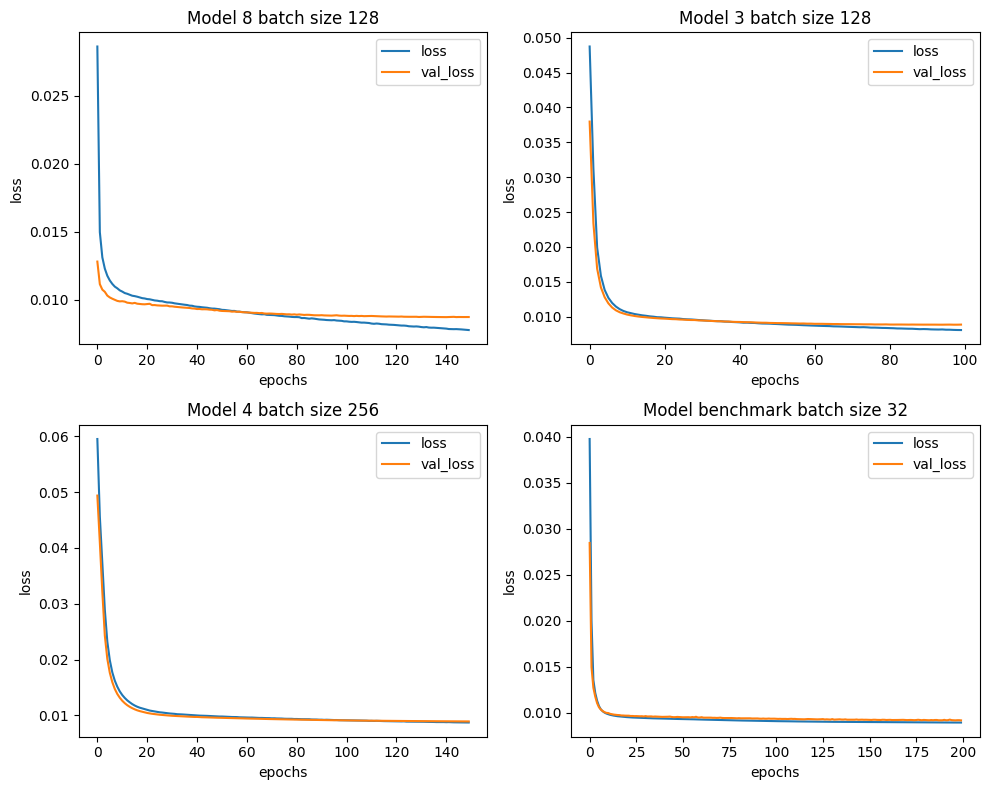

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i in range(len(best_nns_df)):
    model = best_nns_df['model'].to_numpy()[i]
    epoch = best_nns_df['epochs'].to_numpy()[i]
    batch = best_nns_df['batch_size'].to_numpy()[i]
    sns.lineplot( x=range(len(best_nns_df['loss'].to_numpy()[i])), y=best_nns_df['loss'].to_numpy()[i],ax=axes[i//2,i%2],label='loss')
    sns.lineplot( x=range(len(best_nns_df['val_loss'].to_numpy()[i])), y=best_nns_df['val_loss'].to_numpy()[i],ax=axes[i//2,i%2],label='val_loss')
    axes[i//2,i%2].set_title('Model '+str(model)+ ' batch size '+str(batch))
    axes[i//2,i%2].set_xlabel('epochs')
    axes[i//2,i%2].set_ylabel('loss')


plt.tight_layout()
plt.show()

### NN test

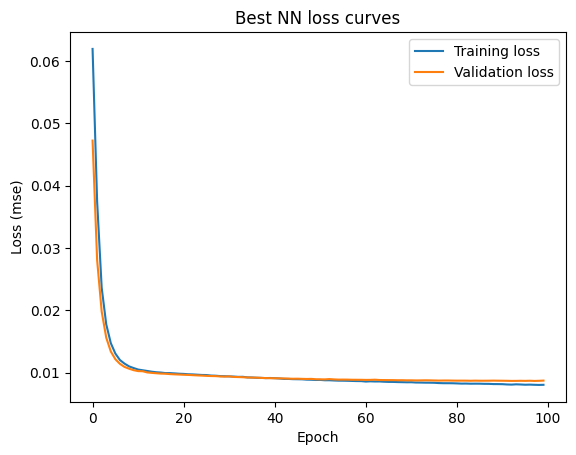

295/295 [==============================] - 1s 2ms/step
{'MSE': 694858.9657873412, 'RMSE': 833.5820090353086, 'MAE': 600.005604362043, 'MAPE': 26.97727620693146, 'R2': 0.770520244851845}


In [63]:
# scale features and y
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_train_scaled= scaler_x.fit_transform(x_train_val)
x_test_scaled= scaler_x.transform(x_test)

y_train_scaled = scaler_y.fit_transform(np.array(y_train_val).reshape(-1, 1))
y_test_scaled= scaler_y.transform(np.array(y_test).reshape(-1, 1))

#train model
nn_model = models_dct['3']()
nn_model.compile(optimizer= tf.optimizers.Adam(), loss='mse')
history = nn_model.fit(x_train_scaled, y_train_scaled,epochs=100, batch_size=128,validation_data = (x_test_scaled,y_test_scaled),verbose=0)

#visualize loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.title(f'Best NN loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.legend()
plt.show()

y_pred_val = nn_model.predict(x_test_scaled) # predict values
metrics_val= compute_metrics_dct(np.exp(y_test),np.exp(scaler_y.inverse_transform(y_pred_val))) #evaluate metrics
print(metrics_val)